# Анализ показателей возвращаемости пользователей  и оценка влияния A/B теста на ключевые метрики пользователей мобильной игры.

В данном проекте проведен анализ показателей Retention игроков и оценка итогов A/B–тестирования. 

В ходе тестирования одной гипотезы целевой группе были предложены новые наборы акционных предложений (группа b), у контрольной группы оставалась базовая механика (группа a).

**Цель исследования**: оценить оказанное влияние A/B теста на ключевые метрики и проверить, имеет ли это влияние статистически доказываемую значимость, определить, какой набор акционных предложений можно считать лучшим, и на основе каких метрик стоит принять правильное решение, а также предложить метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, ttest_ind, norm

import time
from datetime import datetime
from tqdm.auto import tqdm

import requests 
from urllib.parse import urlencode

import warnings
warnings.filterwarnings('ignore')

## 1. Анализ показателей Retention игроков.

`Retention` (возвращаемость пользователей) – один из самых важных показателей в компании. Стоит задача описать и визуализировать `retention` игроков по дням/месяцам/годам от даты регистрации игрока.

### 1.1. Получение данных по внешним ссылкам, загрузка датасетов и изучение данных.

In [2]:
# публичные ссылки на файлы Яндекс.Диск

reg_pk = 'https://disk.yandex.ru/d/Rnv5RpXqUQZwkQ'
auth_pk = 'https://disk.yandex.ru/d/QEUn6SPg_ZzxPQ'

In [3]:
def get_yandex_download_url(public_key):
    '''функция принимает публичный ключ и возвращает загрузочную ссылку'''
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    
    final_url = base_url + urlencode(dict(public_key=public_key))
    
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    return download_url

In [4]:
# загрузим наши данные 

# reg_data = pd.read_csv(get_yandex_download_url(reg_pk))
# auth_data = pd.read_csv(get_yandex_download_url(auth_pk))

reg_data = pd.read_csv('data/users_reg_data.csv', sep=';')
auth_data = pd.read_csv('data/users_auth_data.csv', sep=';')

In [5]:
reg_data.head(3)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [6]:
auth_data.head(3)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


Данные получены и загружены корректно, рассмотрим их описание.

### Описание данных

**reg_data.csv** – данные о времени регистрации

-`reg_ts` -  дата регистрации в формате timestamp 
- `uid` - id пользователя 

**auth_data.csv** – данные о времени захода пользователей в игру

- `auth_ts` - дата захода пользователя в игру в формате timestamp 	
- `uid` - id пользователя 

Выведем случайные 5 строк, общую информацию о каждом датасете (вместе с информацией об абсолютном и относительном количестве пропусков), основные статистики по столбцам и количество явных дубликатов.

Для удобства работы весь процесс реализуем через функции.

In [7]:
def nans(df):
    '''
    функция выводит количество пропусков в каждом столбце 
    и их долю от общего количества данных в столбце
    '''   
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 2)
    
    missing_value_df = pd.DataFrame({'num_missing': count_missing,
                                     'percent_missing': percent_missing})
    
    return missing_value_df.reset_index().rename(columns={'index':'column'})

In [8]:
def info_dataframe(data, details=False):
    '''функция преобразует df.info() в датафрейм'''
    
    dfInfo = data.columns.to_frame(name='column')
    dfInfo['dtype'] = data.dtypes
    dfInfo['non_null_count'] = data.notna().sum()  
    dfInfo.reset_index(drop=True, inplace=True)
    
    if details:
        rangeIndex = (dfInfo['non_null_count'].min(), dfInfo['non_null_count'].min())
        totalColumns = dfInfo['column'].count()
        dtypesCount = dfInfo['dtype'].value_counts()
        totalMemory = dfInfo.memory_usage().sum()
        return dfInfo, rangeIndex, totalColumns, dtypesCount, totalMemory
    else:
        return dfInfo

In [9]:
def all_info(df):
    '''
    функция выводит случайные 5 строк, информацию по датафрейму, 
    включая пропуски и их долю, статистики и кол-во дубликатов
    '''
    display(df.sample(5))
    print(f'Датафрейм содержит {df.shape[0]} записей и {df.shape[1]} колонки')
    all_info_df = info_dataframe(df).merge(nans(df), on='column')
    display(all_info_df)
    display(df.describe()) 
    print(f'Количество явных дубликатов в датафрейме {df.duplicated().sum()}')

In [10]:
all_info(reg_data)

,reg_ts,uid
505928,1565073464,561610
552081,1569660496,612852
757243,1586263565,840994
408670,1553856240,453682
658052,1578886497,730825


Датафрейм содержит 1000000 записей и 2 колонки


,column,dtype,non_null_count,num_missing,percent_missing
0,reg_ts,int64,1000000,0,0.0
1,uid,int64,1000000,0,0.0


,reg_ts,uid
count,1.000000e+06,1.000000e+06
mean,1.548332e+09,5.552354e+05
std,5.253653e+07,3.206011e+05
min,9.113822e+08,1.000000e+00
25%,1.528034e+09,2.776438e+05
50%,1.564454e+09,5.550455e+05
75%,1.585759e+09,8.329712e+05
max,1.600874e+09,1.110622e+06


Количество явных дубликатов в датафрейме 0


Датасет с информацией о регистрациях:
    
- содержит 1000000 записей и 2 колонок,
- не содержит пропусков и явных дубликатов,
- колонка сметкой времени `reg_ts` не приведена к типу datetime.

In [11]:
all_info(auth_data)

,auth_ts,uid
3012422,1540220962,350192
8364886,1593667335,245919
8161144,1592377022,240905
3430431,1547016050,342952
1397546,1500334488,112267


Датафрейм содержит 9601013 записей и 2 колонки


,column,dtype,non_null_count,num_missing,percent_missing
0,auth_ts,int64,9601013,0,0.0
1,uid,int64,9601013,0,0.0


,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


Количество явных дубликатов в датафрейме 0


Датасет с информацией об аутентификациях:
    
- содержит 9601013 записей и 2 колонки,
- не содержит пропусков и явных дубликатов,
- колонка с меткой времени `auth_ts` не приведена к типу datetime.

Подготовим данные для дальнейшего анализа, приведя столбцы с датами к нужному типу данных и смерджив таблицы друг с другом.

In [12]:
# объединим данные в одну таблицу

reg_auth_data = auth_data.merge(reg_data, how='left', on='uid')
reg_auth_data.head(3)

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089


In [13]:
# приведем столбцы с timestamp к типу datetime и оставим из нее только данные о дате

reg_auth_data['auth_date'] = pd.to_datetime(reg_auth_data['auth_ts'], unit='s').dt.date
reg_auth_data['reg_date'] = pd.to_datetime(reg_auth_data['reg_ts'], unit='s').dt.date
reg_auth_data.head(3)

,auth_ts,uid,reg_ts,auth_date,reg_date
0,911382223,1,911382223,1998-11-18,1998-11-18
1,932683089,2,932683089,1999-07-22,1999-07-22
2,932921206,2,932683089,1999-07-25,1999-07-22


In [14]:
# посмотрим диапазон дат в наших данных

print('Первая регистрация   : ', reg_auth_data['reg_date'].min())
print('Первая авторизация   : ', reg_auth_data['auth_date'].min())
print('Последняя регистрация: ', reg_auth_data['reg_date'].max())
print('Последняя авторизация: ', reg_auth_data['auth_date'].max())

Первая регистрация   :  1998-11-18
Первая авторизация   :  1998-11-18
Последняя регистрация:  2020-09-23
Последняя авторизация:  2020-09-23


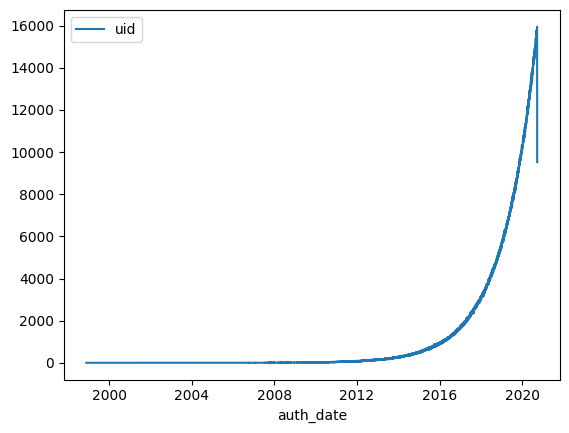

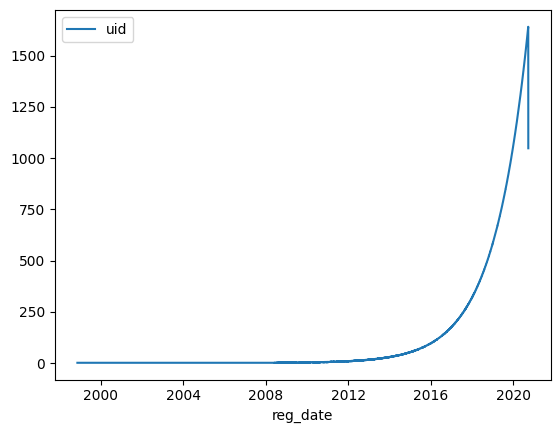

In [15]:
# посмотрим на график регитраций и активности

reg_auth_data.groupby('auth_date').agg({'uid':'nunique'}).plot()
reg_auth_data.groupby('reg_date').agg({'uid':'nunique'}).plot();

**Вывод**

В нашем распоряжении находятся данные о регистрации и аутентификации игроков за временной период с 18 ноября 1998 года по 23 сентября 2020 года. При этом активный рост количества игроков начался только в 2015м году и продолжается вплоть до конечной даты.

Данных много, то есть проблем с малым размером выборки нет, графики `retention` за разные периоды, даже годы, будут показательны.

### 1.2.1. Когортный анализ аудитории по дням.

Напишем функцию, которая будет визуализировать `retention` игроков по дням, причем таким образом, чтобы мы могли сами регулировать временной период.

In [16]:
def retention_days(start_date, end_date, df):
    '''функция осуществляет когортный анализ по дням
    на вход подается: 
    start_date - начальная дата
    end_date - конечная дата
    df - предобработанная таблица с данными
    на выходе получаем:
    cohort_counts - таблица с количеством пользователей в когорте
    график heatmap с визуализацией ретеншена'''
    
    start_date = datetime.fromisoformat(start_date).date()
    end_date = datetime.fromisoformat(end_date).date()
    
    #start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    #end_date = datetime.strptime(end_date, '%Y-%m-%d').date()
    
    # отфильтруем данные за необходимый период
    df = df.query("@start_date <= reg_date <= @end_date and @start_date <= auth_date <= @end_date")
    
    # добавляем вспомогательный столбец с количеством ДНЕЙ с момента регистрации
    df['days_since_reg'] = (df['auth_date'] - df['reg_date']).dt.days + 1
    
    # cоздадим таблицу для когортного анализа, когорты делим по дате регистрации
    # считаем сколько пользователей зарегистрировалось в какой день
    cohorts_day = df.groupby(['reg_date', 'days_since_reg'], as_index=False) \
                     .agg({'uid':'nunique'}) \
                     .pivot(index='reg_date', columns='days_since_reg', values='uid')

    # количество игроков, зарегистрировавшихся в каждый день из диапазона дат
    registrations = cohorts_day[1]

    # делаем таблицу с количеством игроков в каждый день в зависимости от их даты регистрации
    retention = cohorts_day.divide(registrations, axis=0)
    # построим красивую и понятную визуализацию для наших данных
    
    plt.figure(figsize=(25, 25))
    plt.title('% возврата игроков с момента регистрации', fontweight='bold', size=30)
    ax = sns.heatmap(data=retention, vmin=0.0, vmax=0.1, cmap='viridis', 
            fmt='.2%', annot=True, linewidths=1, linecolor='white', square=True, cbar=False)
    plt.ylabel('Дата регистрации', labelpad=20, size=20)
    plt.xlabel('Дней прошло с момента регистрации', labelpad=20, size=20)
    
    # сохраняем изображение в формате .png
    fig = ax.get_figure()
    fig.savefig("retention_days.png")
    
    return cohorts_day

Выведем график за период с 1 января 2018 года по 31 января 2018 года.

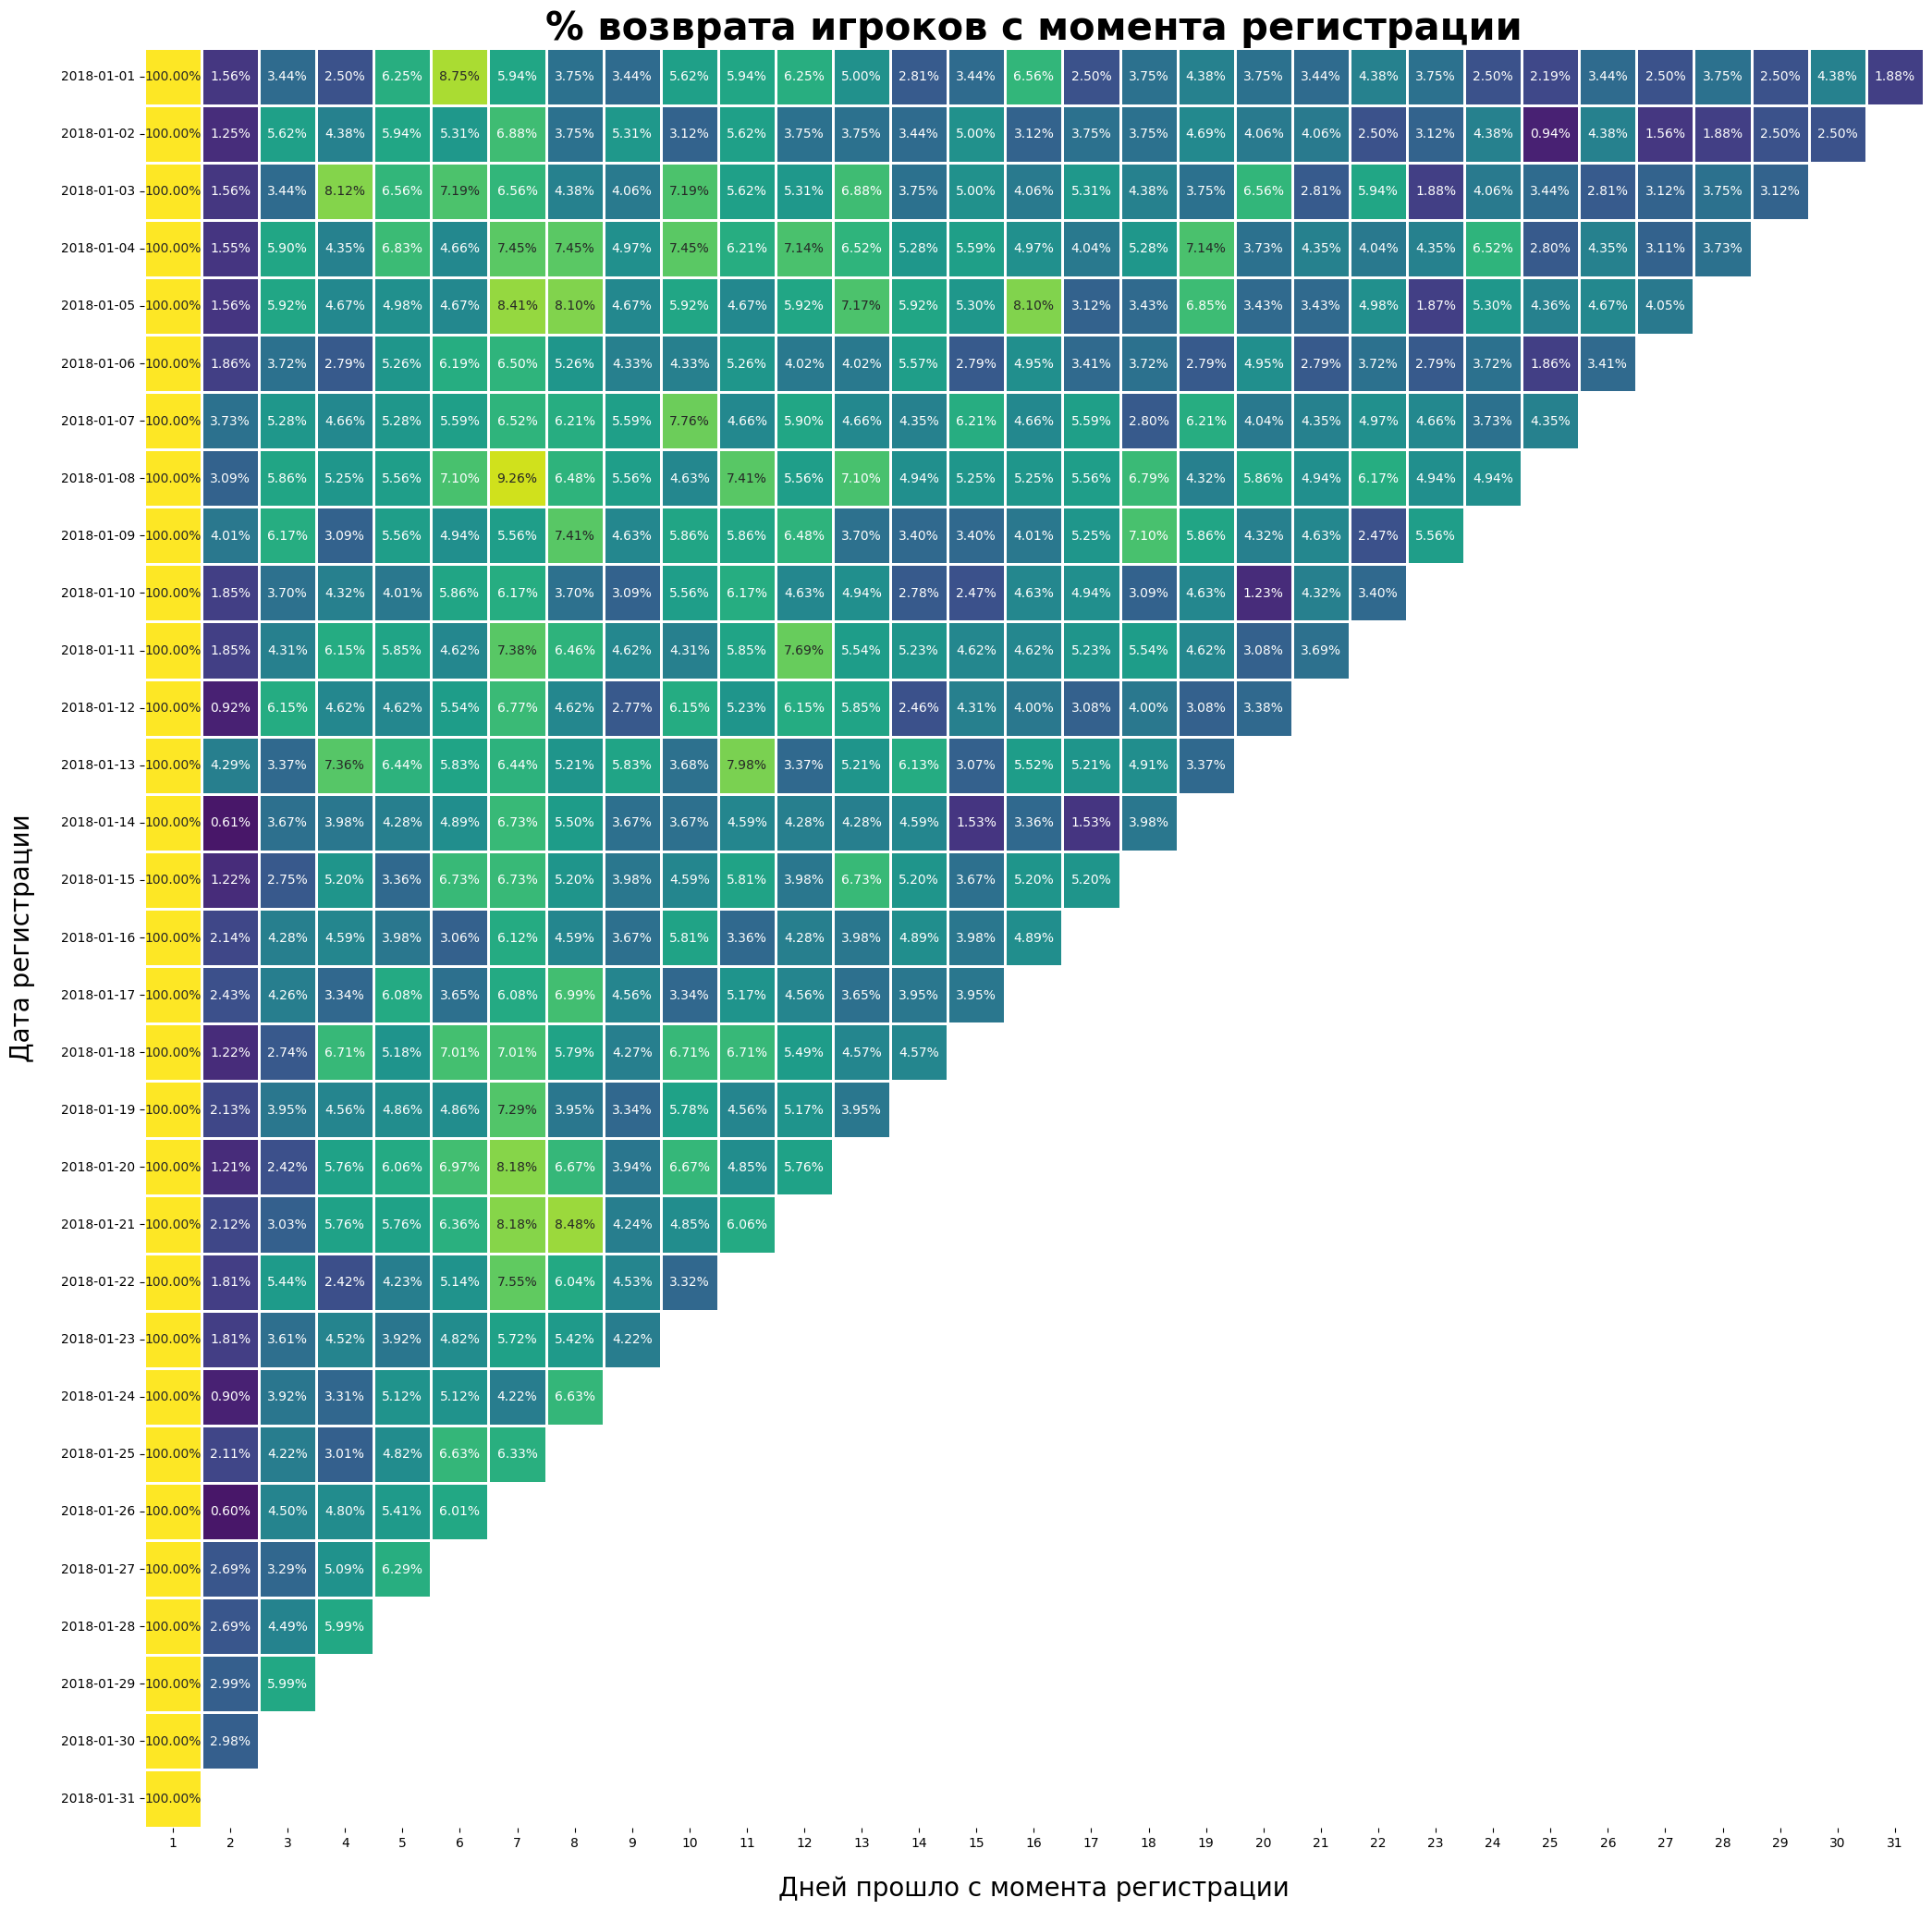

In [17]:
cohorts_days = retention_days('2018-01-01', '2018-01-31', reg_auth_data)

In [18]:
# выведем саму таблицу
cohorts_days 

days_since_reg,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
reg_date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,320.0,5.0,11.0,8.0,20.0,28.0,19.0,12.0,11.0,18.0,...,14.0,12.0,8.0,7.0,11.0,8.0,12.0,8.0,14.0,6.0
2018-01-02,320.0,4.0,18.0,14.0,19.0,17.0,22.0,12.0,17.0,10.0,...,8.0,10.0,14.0,3.0,14.0,5.0,6.0,8.0,8.0,NaN
2018-01-03,320.0,5.0,11.0,26.0,21.0,23.0,21.0,14.0,13.0,23.0,...,19.0,6.0,13.0,11.0,9.0,10.0,12.0,10.0,NaN,NaN
2018-01-04,322.0,5.0,19.0,14.0,22.0,15.0,24.0,24.0,16.0,24.0,...,13.0,14.0,21.0,9.0,14.0,10.0,12.0,NaN,NaN,NaN
2018-01-05,321.0,5.0,19.0,15.0,16.0,15.0,27.0,26.0,15.0,19.0,...,16.0,6.0,17.0,14.0,15.0,13.0,NaN,NaN,NaN,NaN
2018-01-06,323.0,6.0,12.0,9.0,17.0,20.0,21.0,17.0,14.0,14.0,...,12.0,9.0,12.0,6.0,11.0,NaN,NaN,NaN,NaN,NaN
2018-01-07,322.0,12.0,17.0,15.0,17.0,18.0,21.0,20.0,18.0,25.0,...,16.0,15.0,12.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,324.0,10.0,19.0,17.0,18.0,23.0,30.0,21.0,18.0,15.0,...,20.0,16.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,324.0,13.0,20.0,10.0,18.0,16.0,18.0,24.0,15.0,19.0,...,8.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2.2. Когортный анализ аудитории по месяцам.

Аналогично создадим функцию визуализации `retention` по месяцам.

In [19]:
def retention_months(start_date, end_date, df):
    '''функция осуществляет когортный анализ по месяцам
    на вход подается: 
    start_date - начальная дата
    end_date - конечная дата
    df - предобработанная таблица с данными
    на выходе получаем:
    cohort_counts - таблица с количеством пользователей в когорте
    график heatmap с визуализацией ретеншена'''
    
    start_date = datetime.fromisoformat(start_date).date()
    end_date = datetime.fromisoformat(end_date).date()
    
     # отфильтруем данные за необходимый период
    df = df.query("@start_date <= reg_date <= @end_date and @start_date <= auth_date <= @end_date")
    
    df['reg_month'] = pd.to_datetime(df['reg_ts'], unit='s').dt.to_period('M')
    
    # добавляем вспомогательный столбец с количеством МЕСЯЦЕВ с момента регистрации
    df['months_since_reg'] = ((df.auth_date - df.reg_date) / np.timedelta64(1, 'M')).astype(int)
    
    # cоздадим таблицу для когортного анализа, когорты делим по месяцу регистрации
    # считаем сколько пользователей зарегистрировалось в какой месяц
    cohorts_month = df.groupby(['reg_month', 'months_since_reg'], as_index=False)\
                      .agg({'uid': 'nunique'})\
                      .pivot(index='reg_month', columns='months_since_reg', values='uid')

    # количество игроков, зарегистрировавшихся в каждый день из диапазона дат
    registrations = cohorts_month[0]

    # делаем таблицу с количеством игроков в каждый день в зависимости от их даты регистрации
    retention = cohorts_month.divide(registrations, axis=0)
    # построим красивую и понятную визуализацию для наших данных
    
    plt.figure(figsize=(25, 25))
    plt.title('% возврата игроков с момента регистрации', fontweight='bold', size=30)
    ax = sns.heatmap(data=retention, vmin=0.0, vmax=0.2, cmap='viridis', 
            fmt='.2%', annot=True, linewidths=1, linecolor='white', square=True, cbar=False)
 
    plt.ylabel('Дата регистрации', labelpad=20, size=20)
    plt.xlabel('Месяцев прошло с момента регистрации', labelpad=20, size=20)
    
    # сохраняем изображение в формате .png
    fig = ax.get_figure()
    fig.savefig("retention_months.png")
    
    return cohorts_month

Рассмотрим график возвращаемости пользователей по месяцам за полный 2018й год.

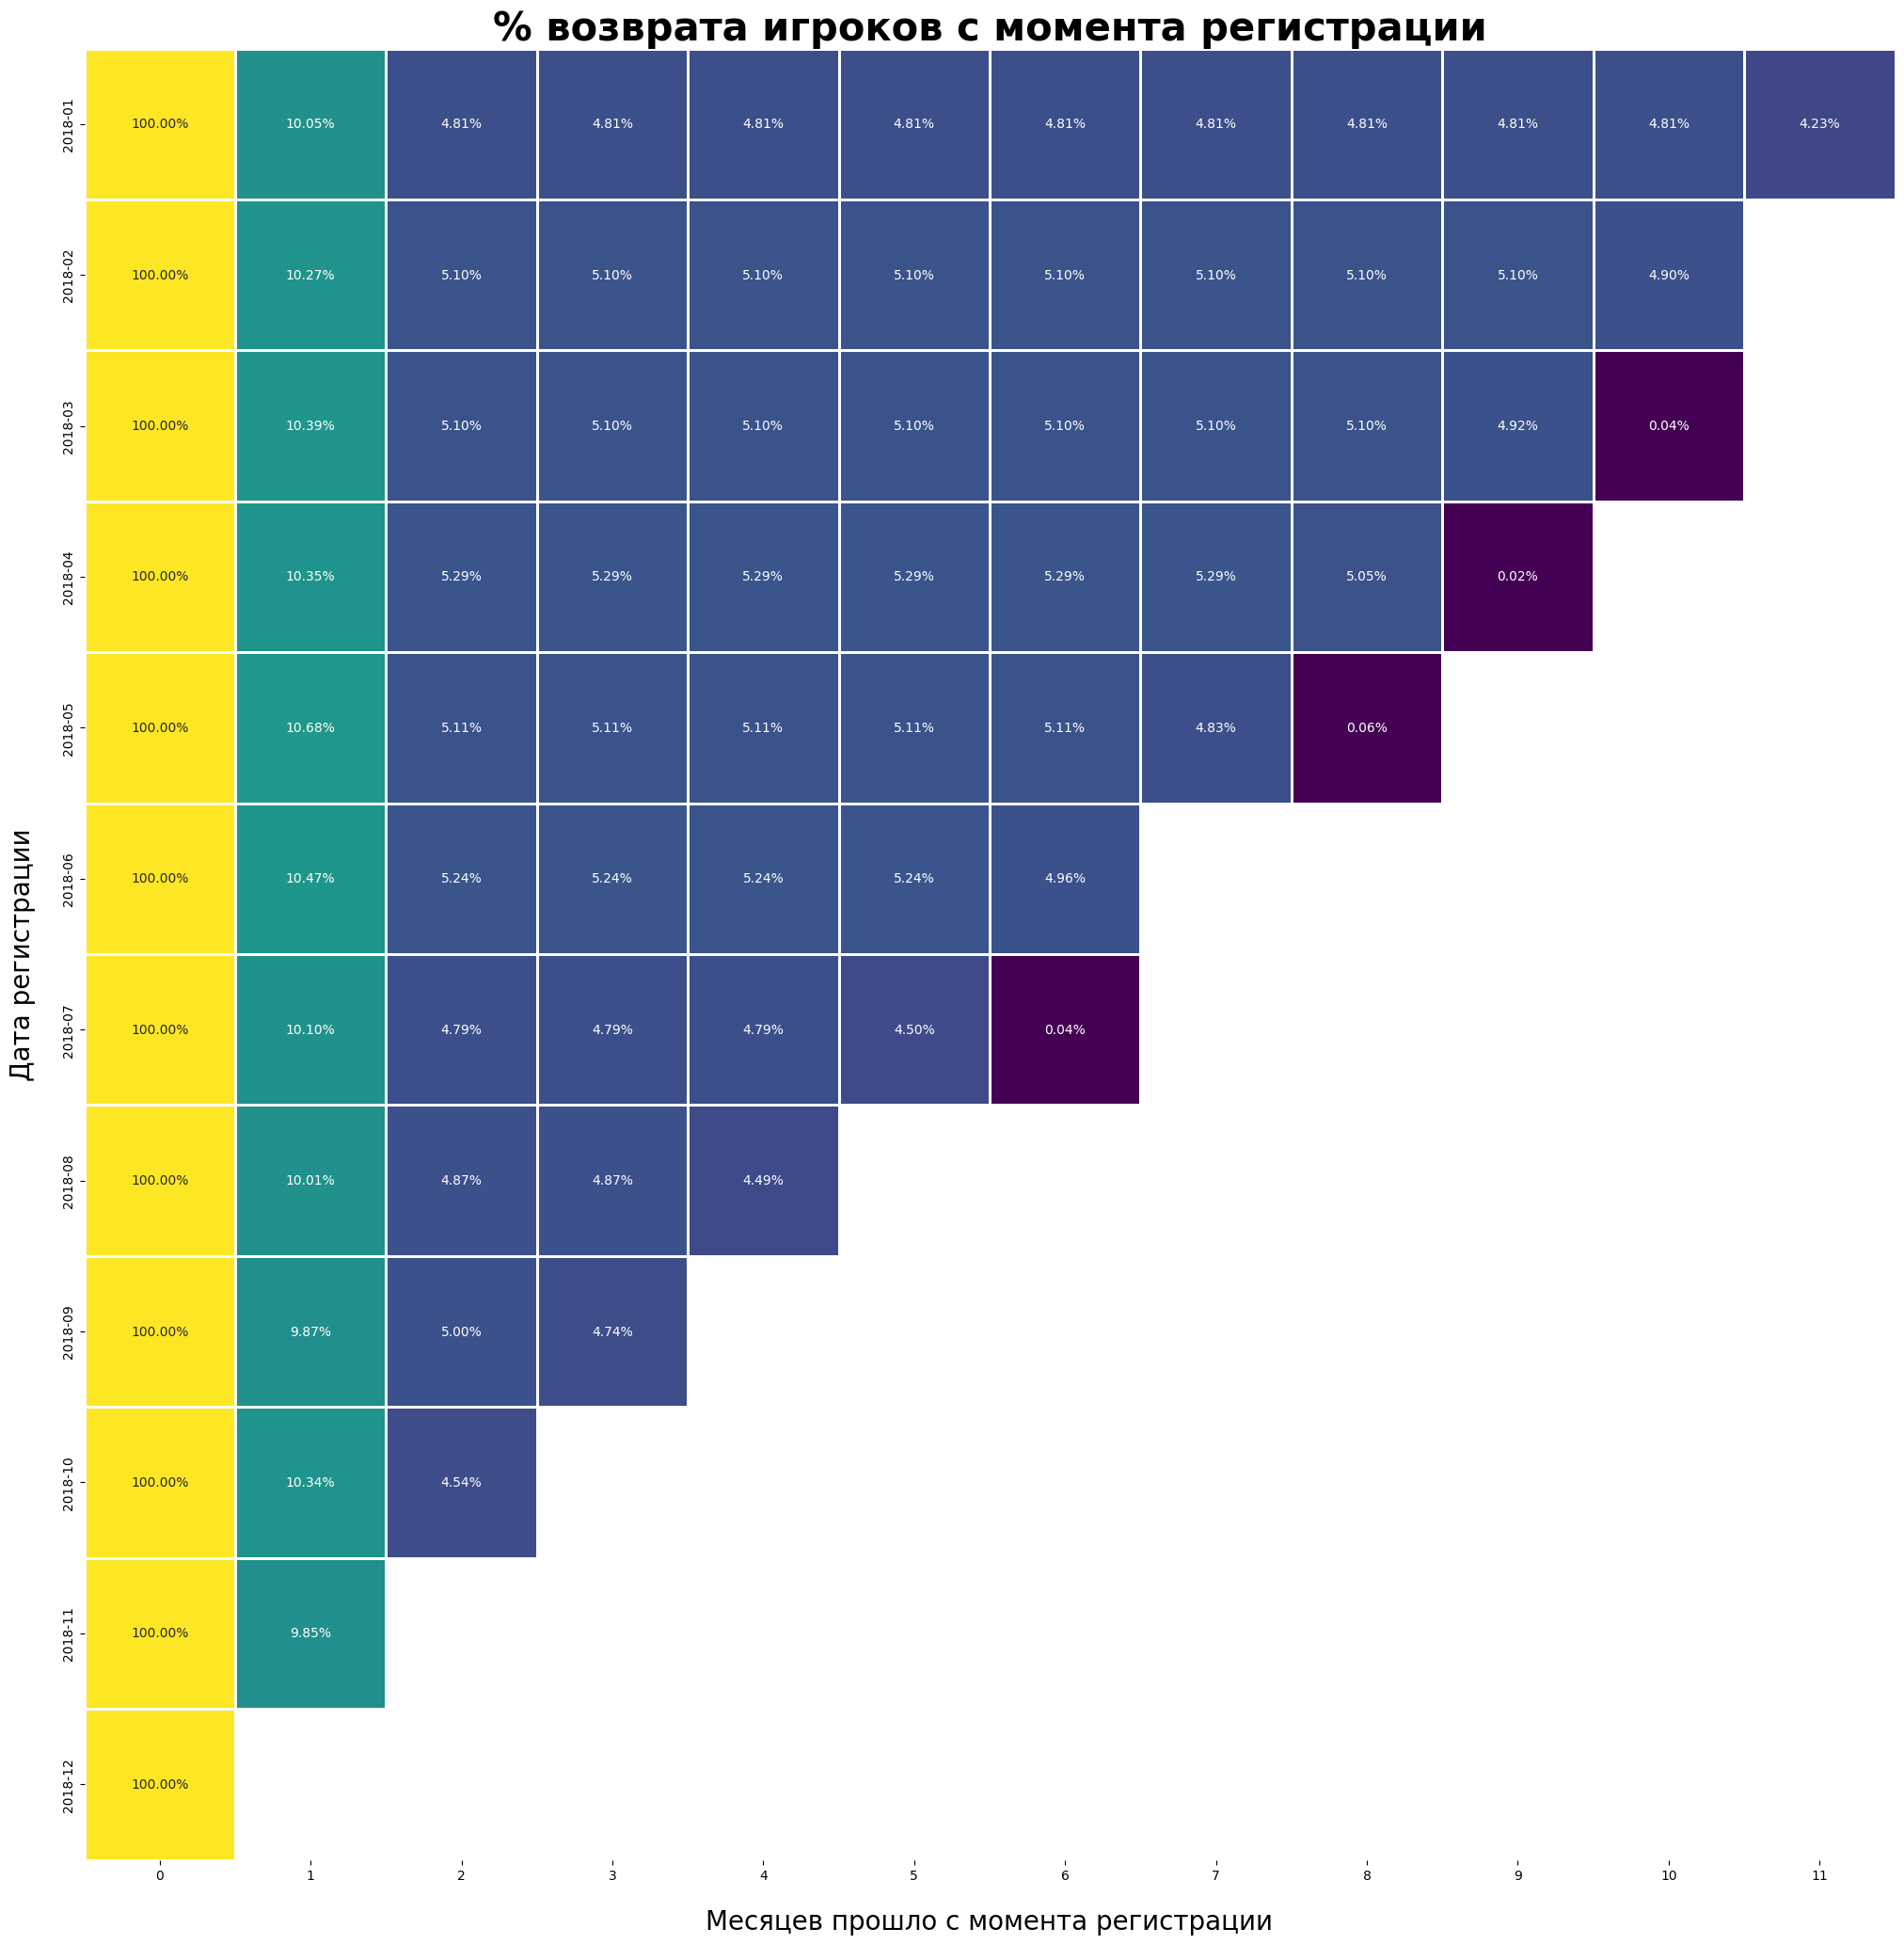

In [20]:
cohorts_months = retention_months('2018-01-01', '2018-12-31', reg_auth_data)

In [21]:
cohorts_months

months_since_reg,0,1,2,3,4,5,6,7,8,9,10,11
reg_month,,,,,,,,,,,,
2018-01,10156.0,1021.0,488.0,488.0,488.0,488.0,488.0,488.0,488.0,488.0,488.0,430.0
2018-02,9630.0,989.0,491.0,491.0,491.0,491.0,491.0,491.0,491.0,491.0,472.0,NaN
2018-03,11191.0,1163.0,571.0,571.0,571.0,571.0,571.0,571.0,571.0,551.0,5.0,NaN
2018-04,11387.0,1178.0,602.0,602.0,602.0,602.0,602.0,602.0,575.0,2.0,NaN,NaN
2018-05,12372.0,1321.0,632.0,632.0,632.0,632.0,632.0,597.0,8.0,NaN,NaN,NaN
2018-06,12588.0,1318.0,660.0,660.0,660.0,660.0,624.0,NaN,NaN,NaN,NaN,NaN
2018-07,13678.0,1382.0,655.0,655.0,655.0,615.0,5.0,NaN,NaN,NaN,NaN,NaN
2018-08,14392.0,1441.0,701.0,701.0,646.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09,14645.0,1446.0,732.0,694.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2.3. Когортный анализ аудитории по годам.

И, наконец, рассмотрим ситуацию с `retention` по годам.

In [22]:
def retention_years(start_date, end_date, df):
    '''функция осуществляет когортный анализ по годам
    на вход подается: 
    start_date - начальная дата
    end_date - конечная дата
    df - предобработанная таблица с данными
    на выходе получаем:
    cohort_counts - таблица с количеством пользователей в когорте
    график heatmap с визуализацией ретеншена'''
    
     # отфильтруем данные за необходимый период
    df = df.query("@start_date <= reg_date <= @end_date and @start_date <= auth_date <= @end_date")
    df['reg_year'] = pd.to_datetime(df['reg_ts'], unit='s').dt.year
    
    # добавляем вспомогательный столбец с количеством ЛЕТ с момента регистрации
    df['years_since_reg'] = ((df.auth_date - df.reg_date) / np.timedelta64(1, 'Y')).astype(int)
    
    # cоздадим таблицу для когортного анализа, когорты делим по месяцу регистрации
    # считаем сколько пользователей зарегистрировалось в какой месяц
    cohorts_year = df.groupby(['reg_year', 'years_since_reg'], as_index=False)\
                     .agg({'uid': 'nunique'})\
                     .pivot(index='reg_year', columns='years_since_reg', values='uid')
    
    # отбираем только тех пользователей, у которых период наблюдения равен полному периоду от start_date до end_date
    cohorts_year = cohorts_year.iloc[:-1, :]
    
    # количество зарегистрированных пользователей в каждый год
    registrations = cohorts_year[0]
    
    # делаем таблицу с количеством игроков в каждый день в зависимости от их даты регистрации
    retention = cohorts_year.divide(registrations, axis=0)
    # построим красивую и понятную визуализацию для наших данных
    
    plt.figure(figsize=(25, 25))
    plt.title('% возврата игроков с момента регистрации', fontweight='bold', size=30)
    ax = sns.heatmap(data=retention, vmin=0.0, vmax=0.07, cmap='viridis', 
            fmt='.2%', annot=True, linewidths=1, linecolor='white', square=True, cbar=False)
 
    plt.ylabel('Дата регистрации', labelpad=20, size=20)
    plt.xlabel('Лет прошло с момента регистрации', labelpad=20, size=20)
    
    # сохраняем изображение в формате .png
    fig = ax.get_figure()
    fig.savefig("retention_years.png")
    
    return cohorts_year

Выведем график за весь период наблюдений, то есть от минимальной до максимальной даты регистрации в датасете.

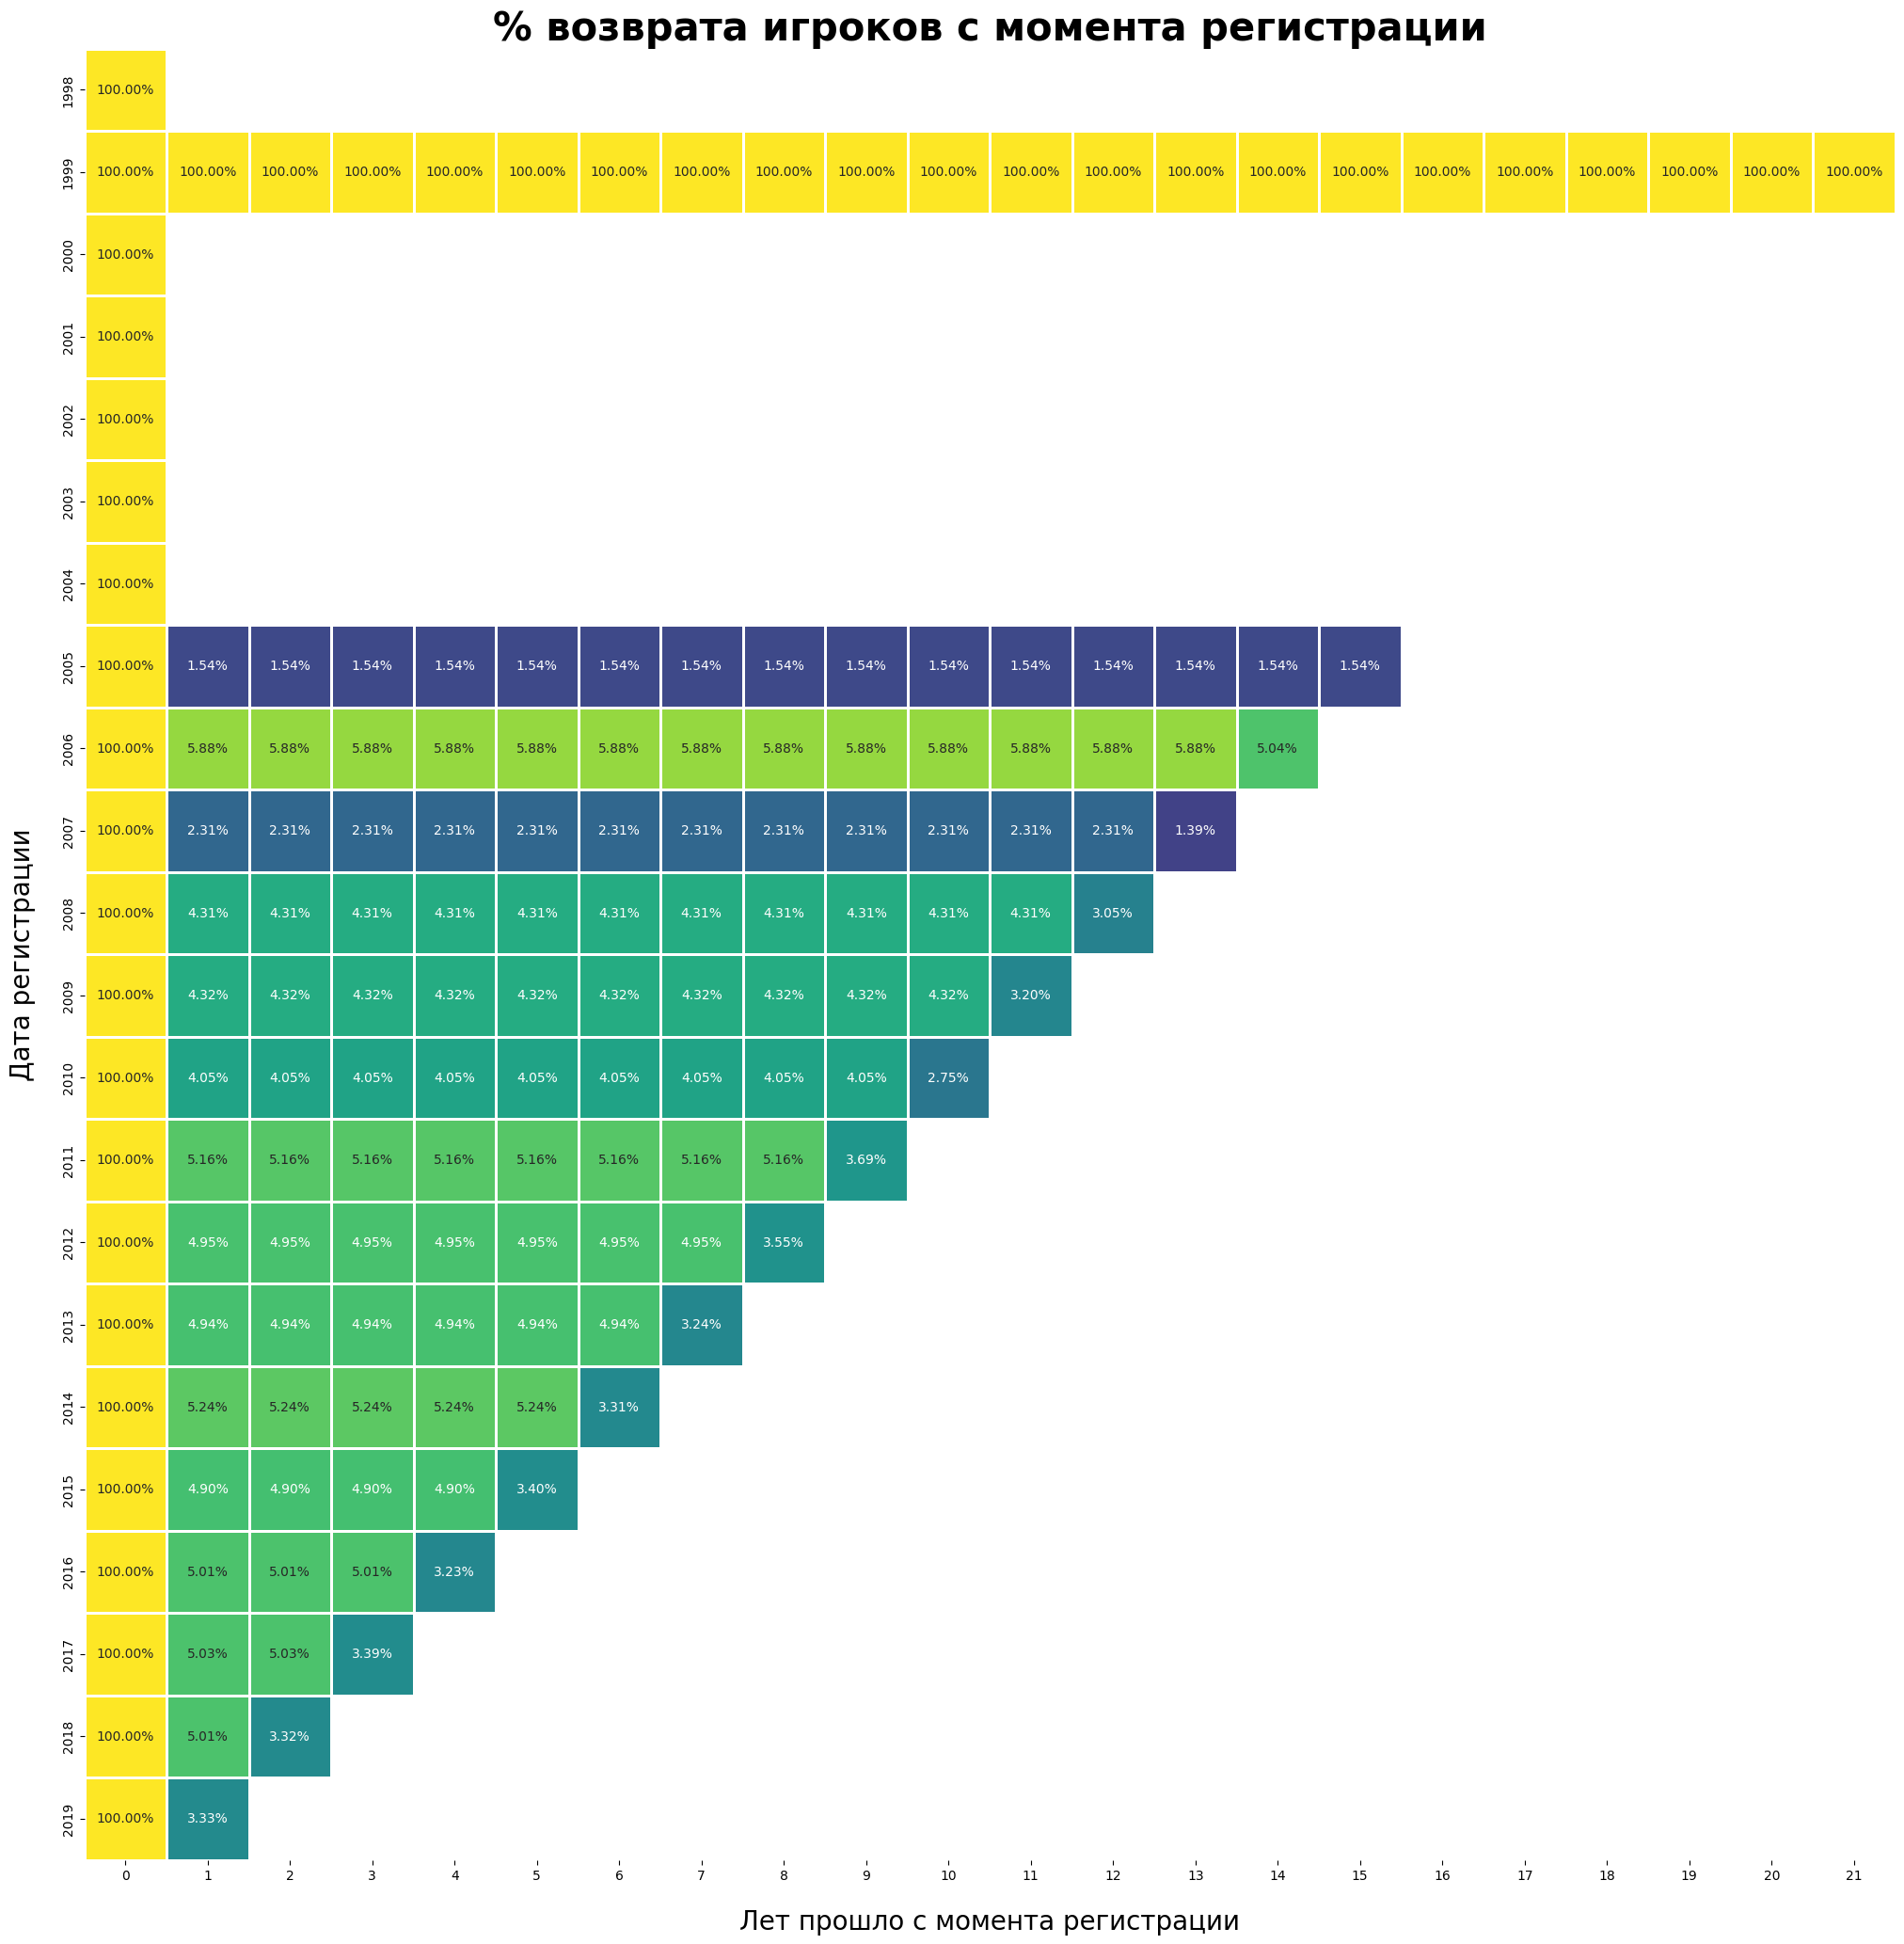

In [23]:
cohorts_years = retention_years(reg_auth_data['reg_date'].min(), reg_auth_data['reg_date'].max(), reg_auth_data)

In [24]:
cohorts_years

years_since_reg,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
reg_year,,,,,,,,,,,,,,,,,,,,,
1998,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,65.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2006,119.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2.4. Вывод когорт в виде линейного графика.

Можно оценить лояльность пользователей и с помощью линейных графиков.

In [25]:
start_date = datetime.fromisoformat('2018-01-01').date()
end_date = datetime.fromisoformat('2018-12-31').date()

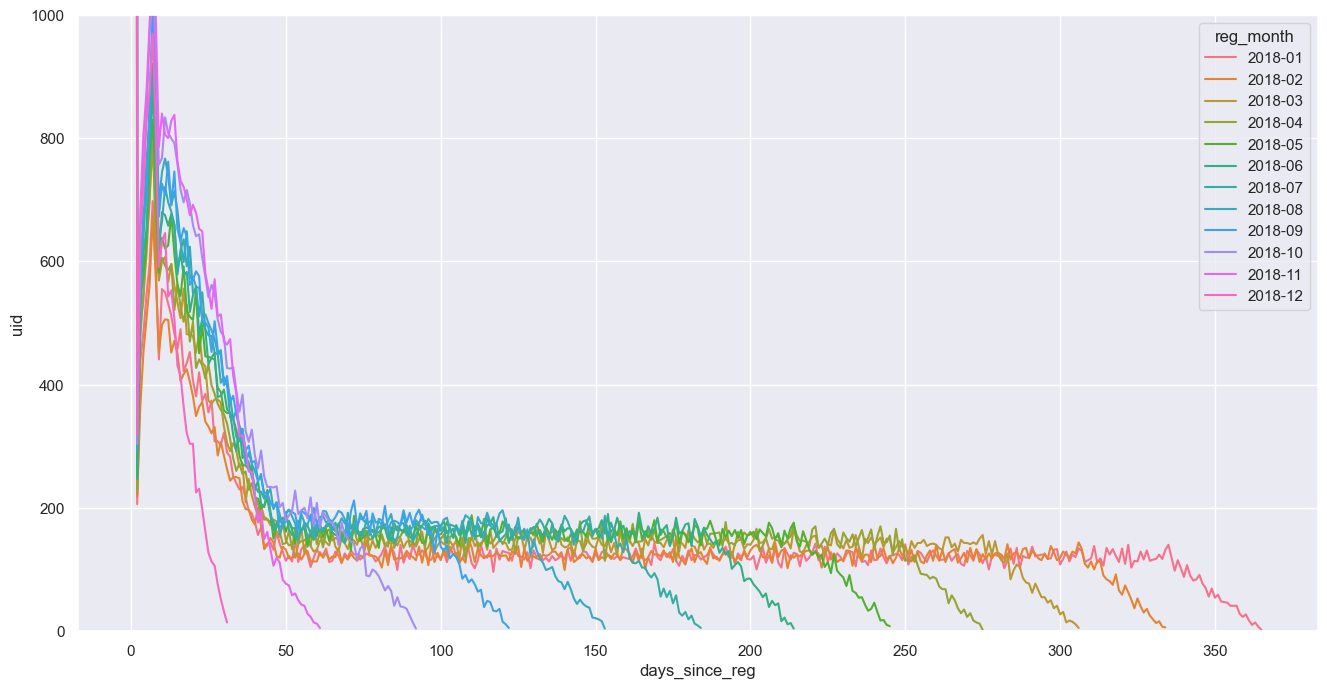

In [26]:
# по месяцам

reg_auth_filtered = reg_auth_data.query("@start_date <= reg_date <= @end_date and @start_date <= auth_date <= @end_date")

reg_auth_filtered['days_since_reg'] = (reg_auth_filtered['auth_date'] - reg_auth_filtered['reg_date']).dt.days + 1
reg_auth_filtered['reg_month'] = pd.to_datetime(reg_auth_filtered['reg_ts'], unit='s').dt.to_period('M')

retention_plot = reg_auth_filtered.groupby(['reg_month', 'days_since_reg'], as_index=False).agg({'uid': 'nunique'})
sns.set(rc={'figure.figsize': (16, 8)})
sns.lineplot(data=retention_plot, x='days_since_reg', y='uid', hue='reg_month')
plt.ylim(0, 1000);

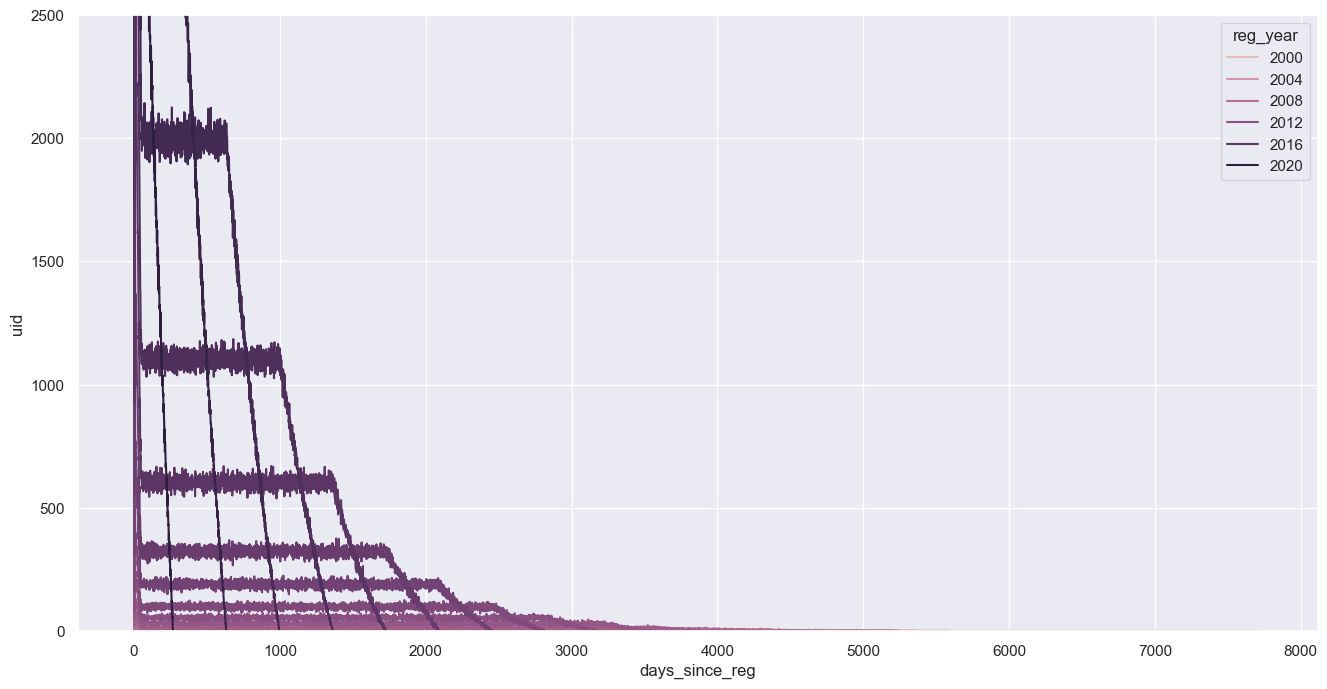

In [27]:
# по годам

reg_auth_unfiltered = reg_auth_data.copy()

reg_auth_unfiltered['days_since_reg'] = (reg_auth_unfiltered['auth_date'] - reg_auth_unfiltered['reg_date']).dt.days + 1
reg_auth_unfiltered['reg_year'] = pd.to_datetime(reg_auth_unfiltered['reg_ts'], unit='s').dt.year

retention_plot = reg_auth_unfiltered.groupby(['reg_year', 'days_since_reg'], as_index=False).agg({'uid': 'nunique'})
sns.set(rc={'figure.figsize': (16, 8)})
sns.lineplot(data=retention_plot, x='days_since_reg', y='uid', hue='reg_year')
plt.ylim(0, 2500);

### 1.2.5. Универсальная функция для анализа Retention пользователей за регулируемый квант времени.

In [28]:
def retention(reg_data, auth_data, period, start_date, end_date, style):
    ''' 
    функция визуализации retention по регулируемым временным квантам и типу визуализации
    на вход поступают:
        - reg_data - данные о регистрации пользователей
        - auth_data - данные о авторизации пользователей в игре
        - period - переменная используется для масштаба графиков и таблиц, принимает значения:
            * 'D' - по дням
            * 'M' - по месяцам
            * 'Y' - по годам
        - start_date - дата начала отчетного периода
        - end_date - дата окончания отчетного периода
        - style - стиль отображения посчитанных данных, принимает значения:
            * 'heatmap' - тепловая карта
            * 'lineplot' - линейный график
            * 'table' - в виде таблицы
    на выходе получаем готовую визуализацию за требуемый период
    '''
    
    # перевод даты начала и конца периода в формат unix-timestamp (как изначально было в таблице)
    start_date = time.mktime(datetime.strptime(start_date, "%Y-%m-%d").timetuple())
    end_date = time.mktime(datetime.strptime(end_date, "%Y-%m-%d").timetuple())
    
    # фильтрация по заданному периоду
    total_df = auth_data.merge(reg_data, how='left', on='uid')\
                        .query('reg_ts >= @start_date and auth_ts <= @end_date')

    # введение вспомогательных фичей для дат
    total_df['auth_date'] = pd.to_datetime(total_df['auth_ts'], unit='s').dt.date
    total_df['reg_date'] = pd.to_datetime(total_df['reg_ts'], unit='s').dt.date

    # рассчет разницы периодов в нужном формате
    total_df['period'] = ((total_df.auth_date - total_df.reg_date) / np.timedelta64(1, period)).astype(int)
    total_df['start'] = pd.to_datetime(total_df['reg_ts'], unit='s').dt.to_period(period)
    
    cohorts = total_df.groupby(['start', 'period'], as_index=False)\
                      .agg({'uid': 'nunique'})\
                      .pivot(index='start', columns='period', values='uid')
    
    if style == 'heatmap':
        plt.figure(figsize=(30, 30))
        plt.title('% возврата игроков', fontweight='bold', size=30)
        sns.heatmap(cohorts.div(cohorts[0], axis=0), vmin=0.0, vmax=0.07, cmap='viridis', 
                    fmt='.1%', annot=True, linewidths=1, linecolor='white', square=True, cbar=False)
        plt.ylabel('Дата регистрации', labelpad=20, size=20)
        plt.xlabel('Времени прошло с момента регистрации', labelpad=20, size=20)
    
    elif style == 'lineplot':
        retention_plot = total_df.groupby(['start', 'period'], as_index=False).agg({'uid': 'nunique'})
        sns.set(rc={'figure.figsize': (16, 8)})
        sns.lineplot(data=retention_plot, x='period', y='uid', hue='start')
        plt.ylim(0, 1000)
    
    elif style == 'table':
        return cohorts
    else:
        return "переменная 'style' задана не верно"

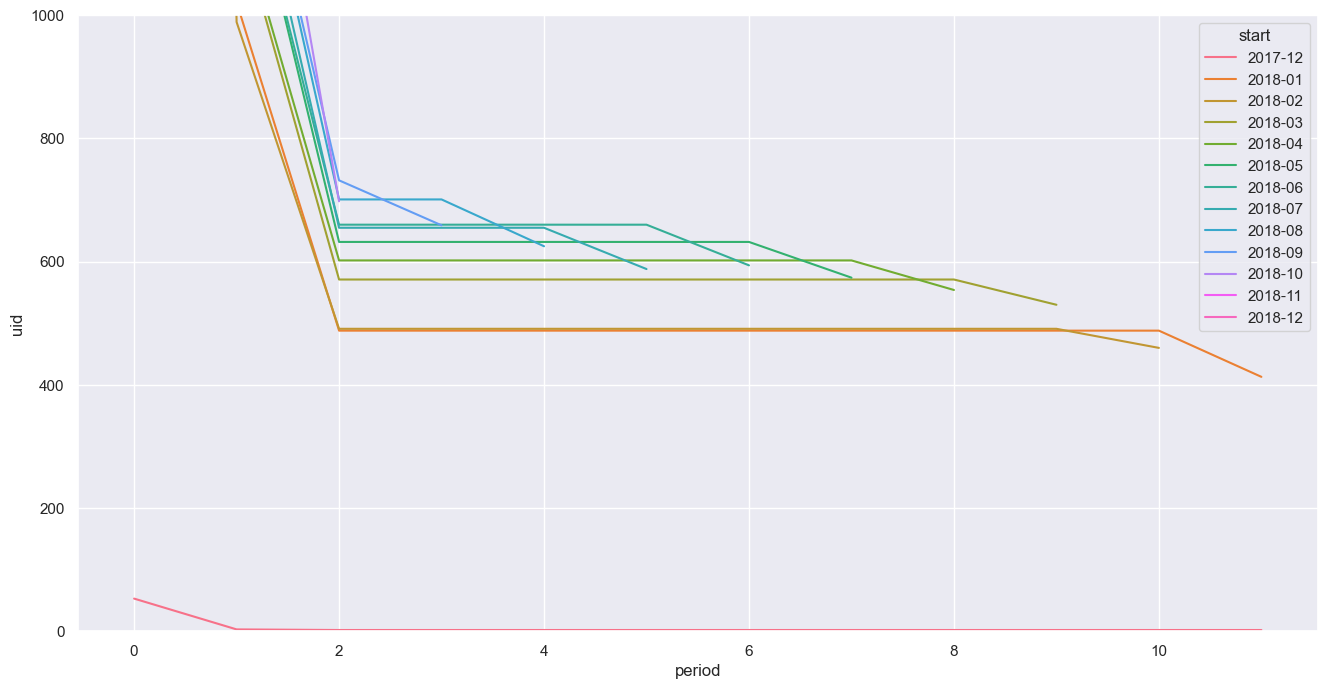

In [29]:
retention(reg_data, auth_data, 'M', '2018-01-01', '2018-12-31', 'lineplot')

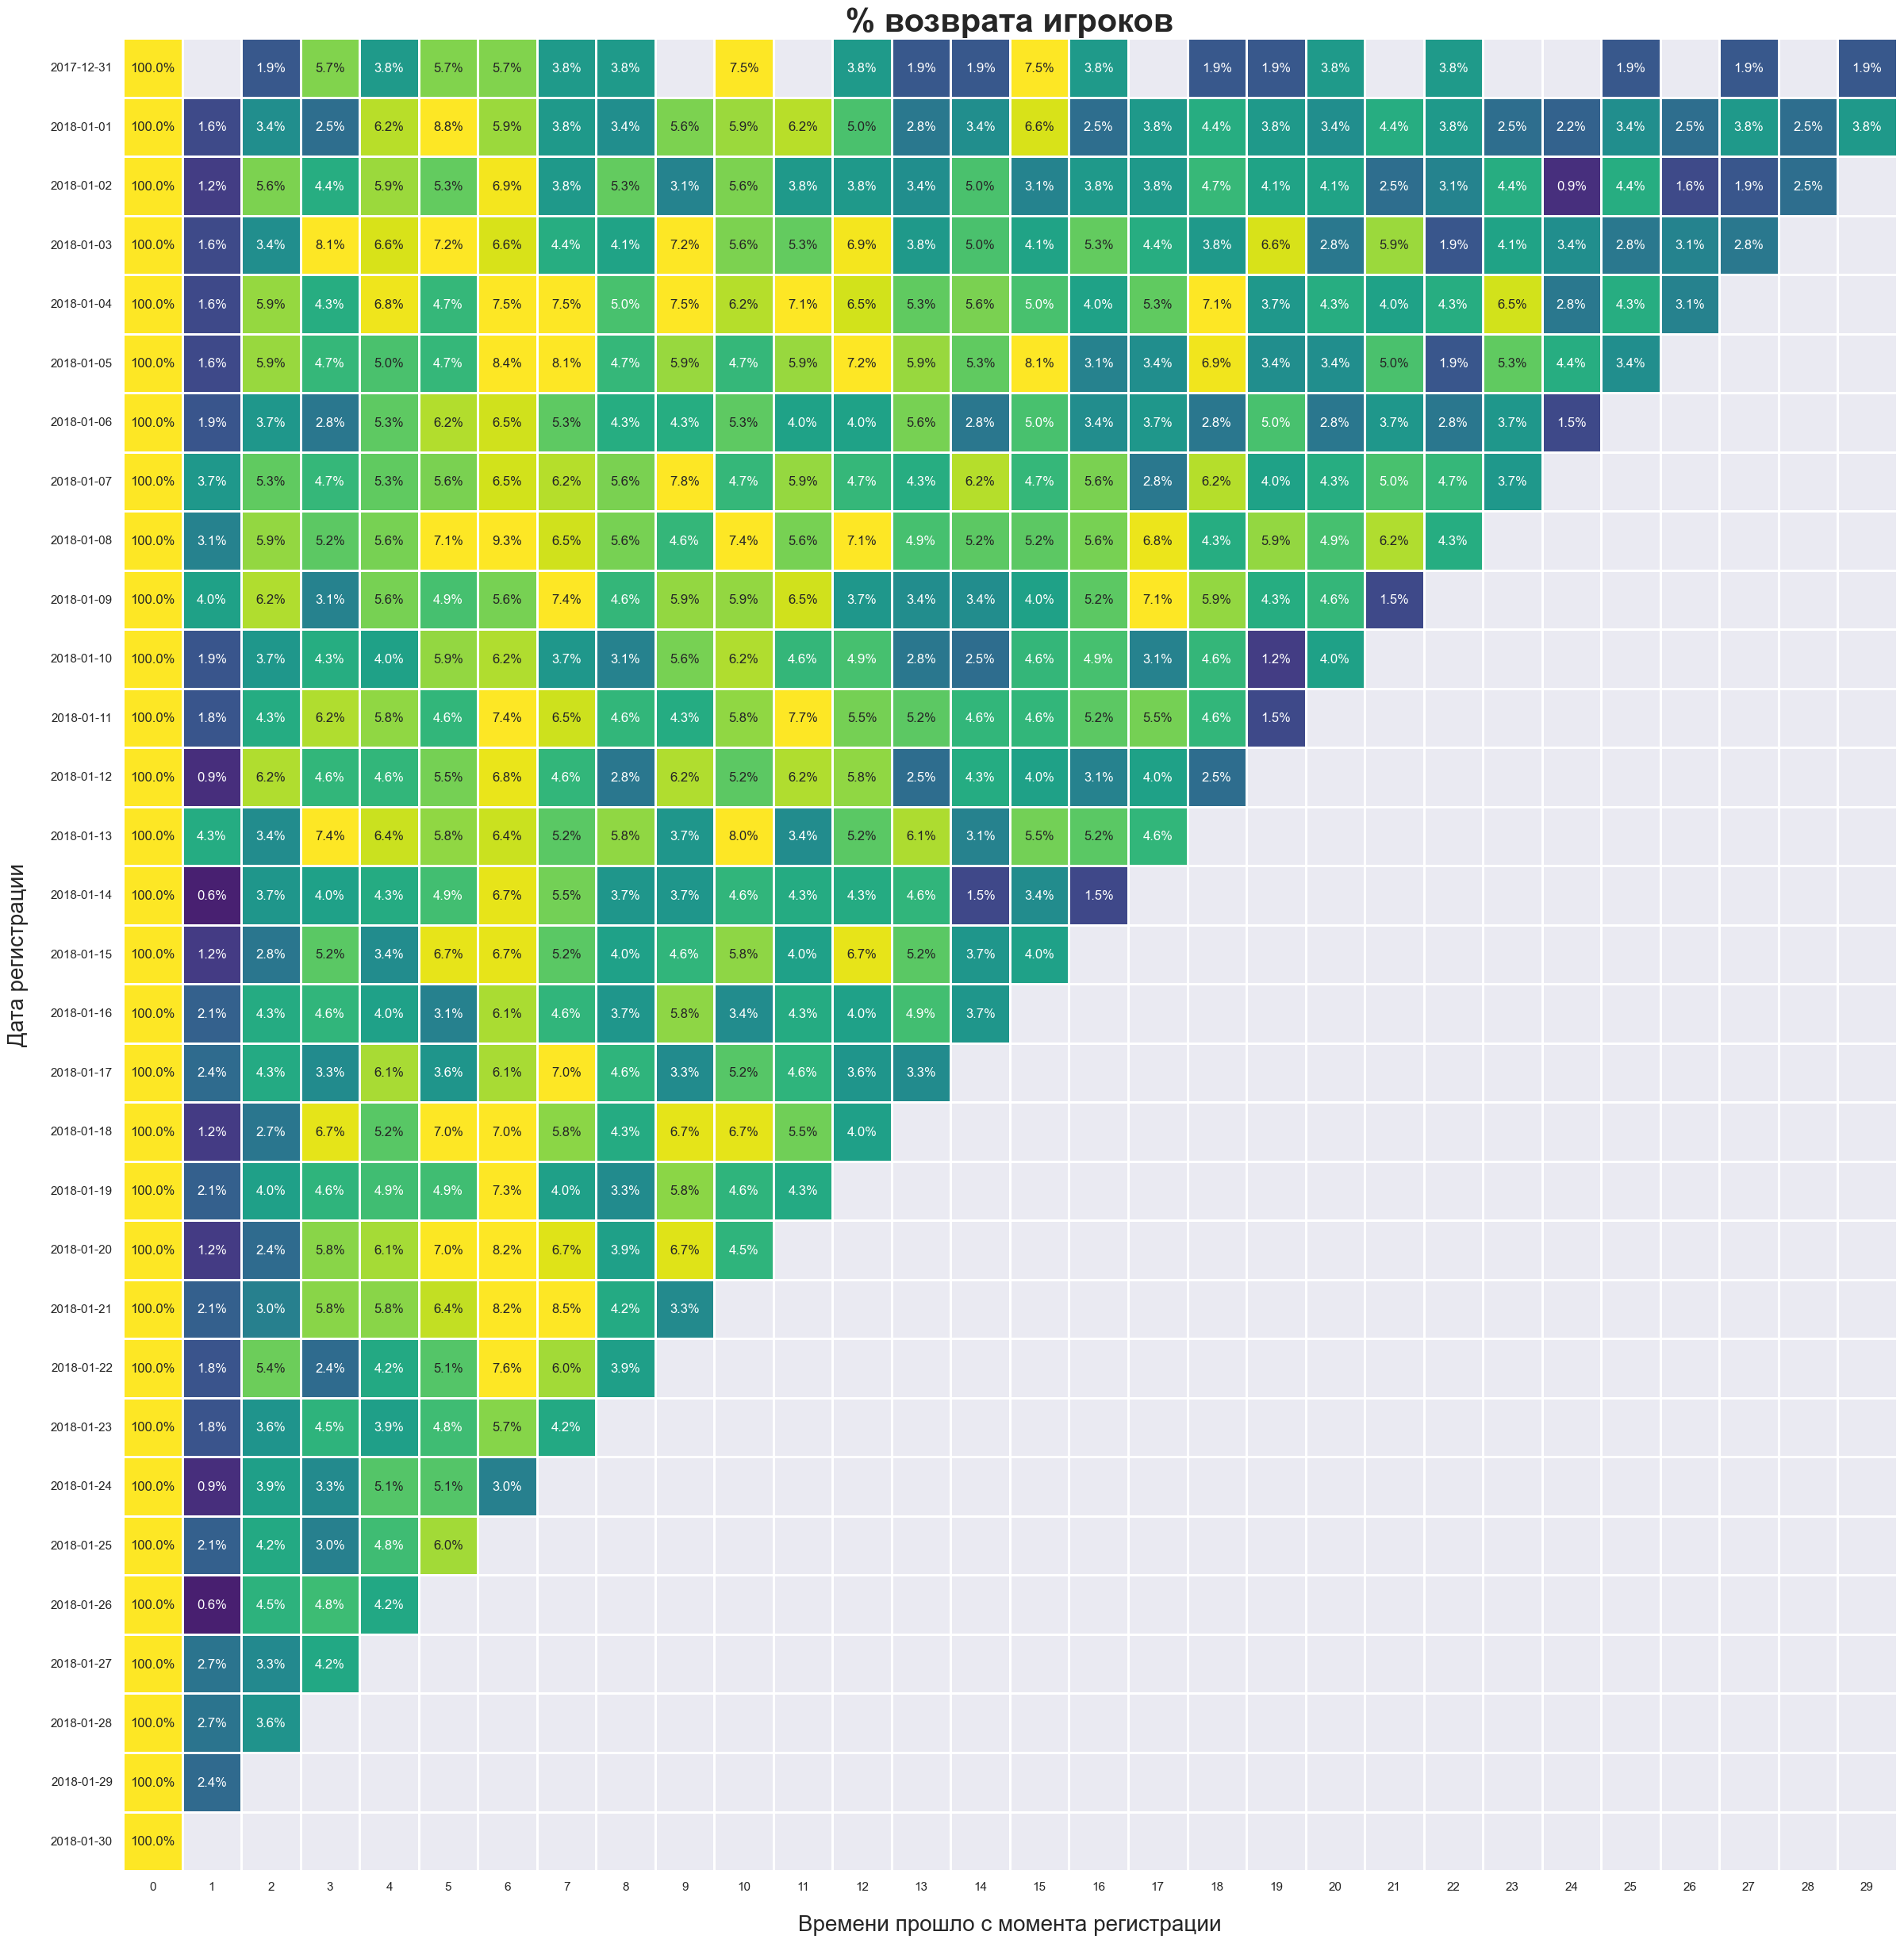

In [30]:
retention(reg_data, auth_data, 'D', '2018-01-01', '2018-01-31', 'heatmap')

In [31]:
retention(reg_data, auth_data, 'D', '2018-01-01', '2018-01-31', 'table')

period,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
start,,,,,,,,,,,,,,,,,,,,,
2017-12-31,53.0,NaN,1.0,3.0,2.0,3.0,3.0,2.0,2.0,NaN,...,2.0,NaN,2.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0
2018-01-01,320.0,5.0,11.0,8.0,20.0,28.0,19.0,12.0,11.0,18.0,...,11.0,14.0,12.0,8.0,7.0,11.0,8.0,12.0,8.0,12.0
2018-01-02,320.0,4.0,18.0,14.0,19.0,17.0,22.0,12.0,17.0,10.0,...,13.0,8.0,10.0,14.0,3.0,14.0,5.0,6.0,8.0,NaN
2018-01-03,320.0,5.0,11.0,26.0,21.0,23.0,21.0,14.0,13.0,23.0,...,9.0,19.0,6.0,13.0,11.0,9.0,10.0,9.0,NaN,NaN
2018-01-04,322.0,5.0,19.0,14.0,22.0,15.0,24.0,24.0,16.0,24.0,...,14.0,13.0,14.0,21.0,9.0,14.0,10.0,NaN,NaN,NaN
2018-01-05,321.0,5.0,19.0,15.0,16.0,15.0,27.0,26.0,15.0,19.0,...,11.0,16.0,6.0,17.0,14.0,11.0,NaN,NaN,NaN,NaN
2018-01-06,323.0,6.0,12.0,9.0,17.0,20.0,21.0,17.0,14.0,14.0,...,9.0,12.0,9.0,12.0,5.0,NaN,NaN,NaN,NaN,NaN
2018-01-07,322.0,12.0,17.0,15.0,17.0,18.0,21.0,20.0,18.0,25.0,...,14.0,16.0,15.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,324.0,10.0,19.0,17.0,18.0,23.0,30.0,21.0,18.0,15.0,...,16.0,20.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Анализ изменения ключевых метрик в результате проведения A/B теста.

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 

Известно, что `ARPU` в тестовой группе выше на 5%, чем в контрольной. 

При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. 

Стоит задача оценить оказанное влияние A/B теста на ключевые метрики и проверить, имеет ли это влияние статистически доказываемую значимость.

### 2.1. Загрузка данных и EDA.

Для начала загрузим датафрейм с результатами эксперимента.

In [32]:
test_res = pd.read_csv('data/ab_test_results.csv', sep=';')
test_res

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Данные загружены корректно, перейдем к их описанию и рассмотрим их более детально.

### Описание данных

- `user_id` - id пользователя
- `revenue` - выручка с пользователя
- `testgroup` -  группа, в которой находился пользователь во время проведения эксперимента (`a` - контрольная, `b` - тестовая).

In [33]:
all_info(test_res)

,user_id,revenue,testgroup
32621,32622,0,a
57759,57760,0,a
249349,249350,0,b
238156,238157,0,a
319558,319559,0,b


Датафрейм содержит 404770 записей и 3 колонки


,column,dtype,non_null_count,num_missing,percent_missing
0,user_id,int64,404770,0,0.0
1,revenue,int64,404770,0,0.0
2,testgroup,object,404770,0,0.0


,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


Количество явных дубликатов в датафрейме 0


Наш датафрейм с результатами эксперимента:
    
- содержит 404770 записей и 3 колонки,
- не содержит пропусков и явных дубликатов,
- значения в колонке с `revenue` распределены крайне неоднородно от 0 до 37433 со средним 26 и медианой 0.

Для удобства последующих рассчетов выделим по отдельности датафреймы для разных экспериментальных групп и по платящим пользователям из этих групп.

In [34]:
a_total = test_res.query('testgroup == "a"')
a_paying = test_res.query('testgroup == "a" & revenue > 0')

b_total = test_res.query('testgroup == "b"')
b_paying = test_res.query('testgroup == "b" & revenue > 0')

In [35]:
# количество пользователей в контрольной группе

users_a = a_total.shape[0]
paying_users_a = a_paying.shape[0]

print('Количество игроков в контрольной группе', users_a)
print('Количество платящих игроков в контрольной группе', paying_users_a)

Количество игроков в контрольной группе 202103
Количество платящих игроков в контрольной группе 1928


In [36]:
# количество пользователей в тестовой группе

users_b = b_total.shape[0]
paying_users_b = b_paying.shape[0]

print('Количество игроков в тестовой группе', users_b)
print('Количество платящих игроков в тестовой группе', paying_users_b)

Количество игроков в тестовой группе 202667
Количество платящих игроков в тестовой группе 1805


In [37]:
# посмотрим на средний revenue между двумя группами, различается он как раз на 5%

test_res.groupby('testgroup').agg(mean_rev = ('revenue', 'mean'))

,mean_rev
testgroup,
a,25.413720
b,26.751287


**Вывод**

Первоначальные предпосылки о количестве пользователей в разных группах и о том, что `ARPU` в тестовой группе выше на 5%, чем в контрольной, подтверждаются.

Общее количество игроков в обоих групах отличается незначительно, то есть поток распределен равномерно, дисбаланса классов не наблюдается.

Количество платящих пользователей в обоих случаях не более 0,9% от общего размера группы.

Так как выявлено аномальное распределение статистик по выручке с пользователей, то следует рассмотреть расределения этго признака для обоих групп.

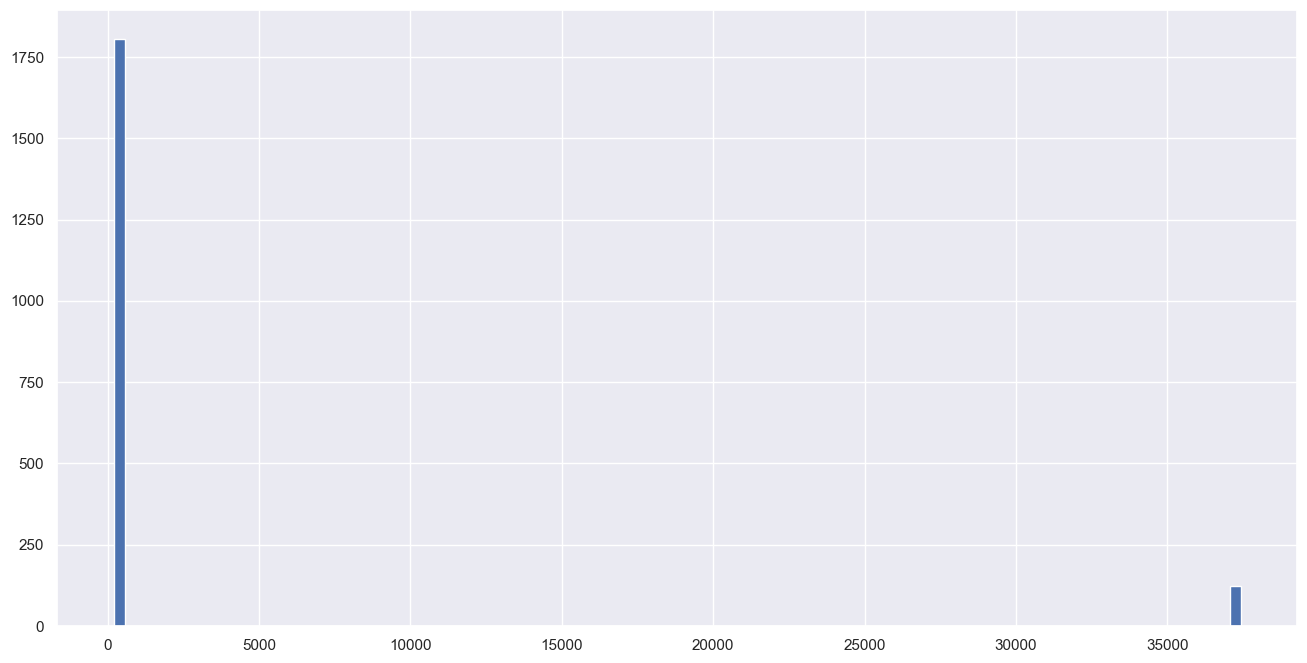

In [38]:
# гистограмма платящих пользователей для контрольной группы
a_paying.revenue.hist(bins=100);

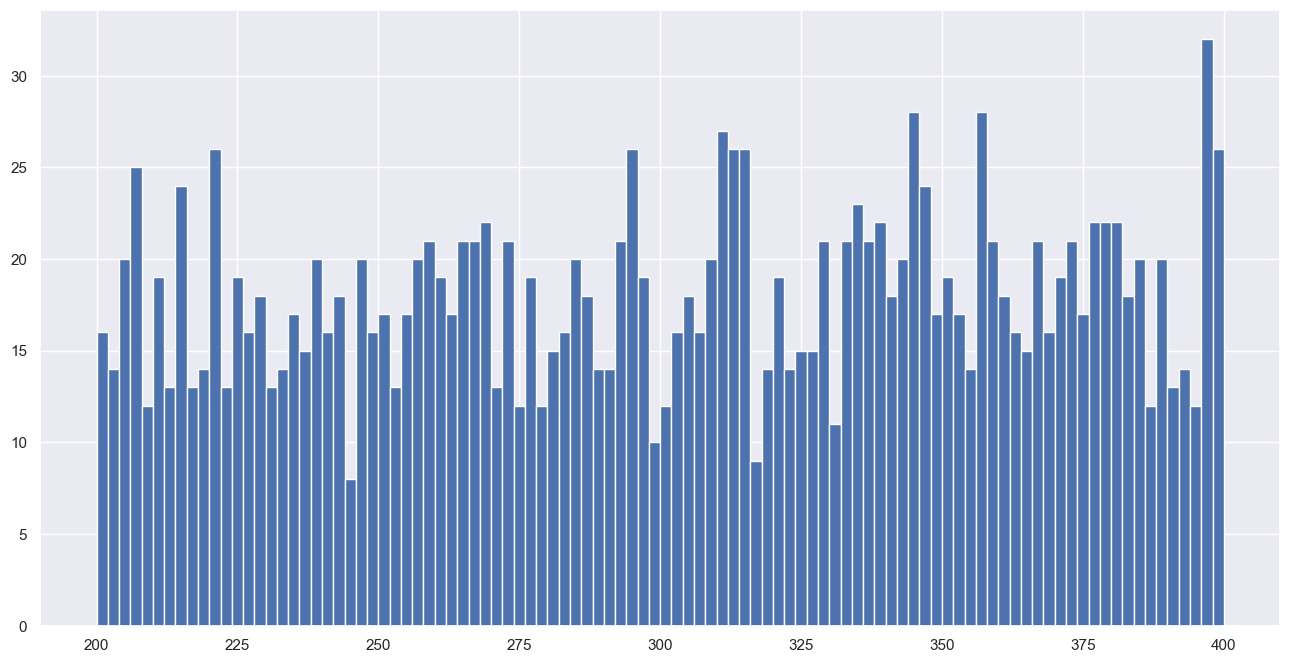

In [39]:
# гистограмма для контрольной группы для пользователей, чей revenue <= 10000
a_paying.query('revenue <= 10000').revenue.hist(bins=100);

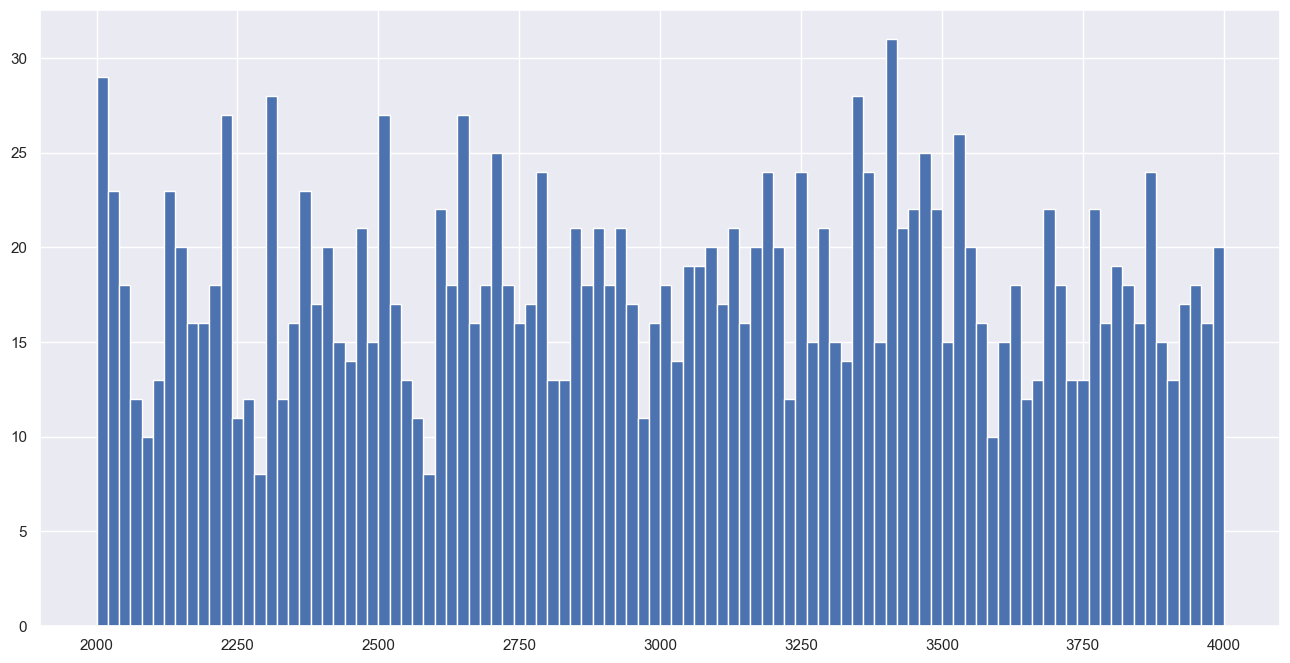

In [40]:
# гистограмма для тестовой группы
b_paying.revenue.hist(bins=100);

Также визуализируем показатели с помощью скрипичного графика.

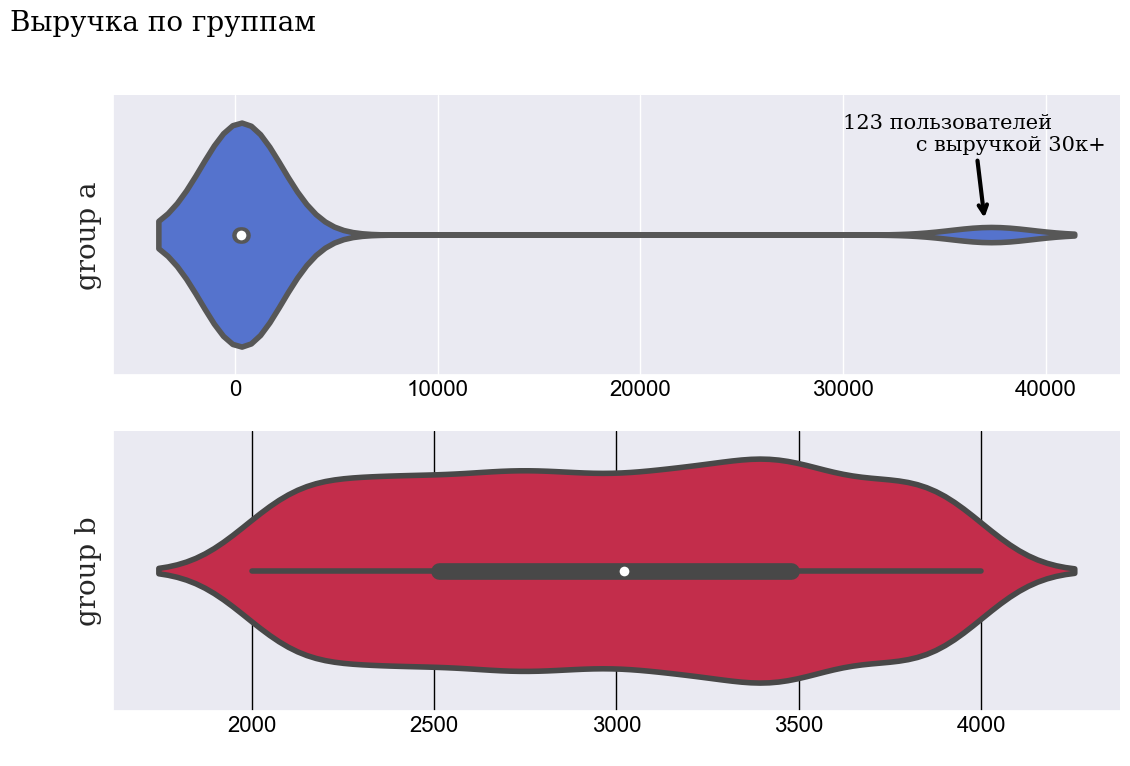

Группа a:
                мин. выручка - 200
                макс. выручка - 37433
                средняя выручка - 2664.0
                медиана - 311.0

Группа b:
                мин. выручка - 2000
                макс. выручка - 4000
                средняя выручка - 3004.0
                медиана - 3022.0



In [41]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(13, 8))

sns.violinplot(data=a_paying, x='revenue',
               ax = ax0,
               color = 'royalblue',
               edgecolor = 'black',
               linewidth = 4)

sns.violinplot(data=b_paying, x='revenue',
               ax = ax1,
               color = 'crimson',
               edgecolor = 'black',
               linewidth = 4)

ax0.annotate(
    text = f'''{len(a_paying.query('revenue > 30000')['revenue'])} пользователей 
           с выручкой 30к+''',
             fontsize = 15,
             color = 'black',
             family = 'serif',
             xy = (37000, -0.05), 
             xytext = (30000, -0.3),
             arrowprops = dict(
                 color = 'black', 
                 arrowstyle = '->', 
                 connectionstyle = 'arc3,rad=-0.',
                 lw = 3)
            )

ax0.set_xlabel(' ')
ax1.set_xlabel(' ')
ax0.set_ylabel('group a',
               fontsize = 20,
               family = 'serif')
ax1.set_ylabel('group b',
               fontsize = 20,
               family = 'serif')

ax0.tick_params(length = 0, 
                width = 0, 
                colors = 'black', 
                labelsize = 16)
ax1.tick_params(length = 0, 
                width = 0, 
                colors = 'black', 
                grid_color = 'black', 
                labelsize = 16)

sns.despine()

ax0.set_title(label = 'Выручка по группам',
          color = 'black',
          fontsize = 20,
          x = 0.05,
          y = 1.2,
          family = 'serif')

plt.show()

for i in ['a', 'b']:
    
    print(f'''Группа {i}:
                мин. выручка - {test_res.query("testgroup == @i & revenue > 0")['revenue'].min()}
                макс. выручка - {test_res.query("testgroup == @i & revenue > 0")['revenue'].max()}
                средняя выручка - {test_res.query("testgroup == @i & revenue > 0")['revenue'].mean().round()}
                медиана - {test_res.query("testgroup == @i & revenue > 0")['revenue'].median().round()}''')
    print()

**Вывод**

По результатам исследовательского анализа данных мы можем сделать следующие выводы:

- в контрольной группе размах выручки в разы больше, чем в тестовой,
- в контрольной группе подавляющее большинство пользователей совершают покупки в диапазоне от 200 до 400, и лишь 123 человека (всего 6,3% от всех платящих пользователей этой группы) совершают очень дорогие покупки на суммы более 30000,
- именно эти пользователи, платящие огромные суммы, сильно сдвигают распределение вправо, мы наблюдаем значительные отличия среднего значения и медианы выручки (отличаются в 8,5 раза),
- распределение выручки в экспериментальной группе более равномерно: все пользователи платят от 2 до 4 тысяч, явных перекосов распределение не имеет, 
- также можно заметить, что медианная выручка экспериментальной группы примерно в 10 раз больше медианной выручки контрольной, то есть по предварительным данным A/B тест положительно влиет на размер выручки с пользователя - однако, нужно доказать статистическую значимость этого эффекта.

### 2.2. Анализ ключевых метрик (конверсия в покупку, средняя выручка с пользователя и средняя выручка с платящего пользователя).

В качестве ключевых метрик для анализа будем рассматривать:

- `CR` (конверсия пользователей в покупку) - нужно сравнить конверсию в разрезе групп и проверить статистическую значимость эффекта с помощью критерия хи-квадрат,
- `ARPU` (средняя выручка на пользователя) - нужно сравнить `ARPU` в разрезе групп и проверить статистическую значимость эффекта с помощью параметрических/непараметрических тестов, а также техники бутстрап,
- `ARPPU` (средняя выручка на платящего пользователя) - нужно сравнить `ARPPU` в разрезе групп и проверить статистическую значимость эффекта с помощью параметрических/непараметрических тестов, а также техники бутстрап.

Для начала просто посчитаем метрики и выведем их.

In [42]:
# выручка по группам
revenue_a = a_paying.revenue.sum()
revenue_b = b_paying.revenue.sum()

print('Revenue контрольной группы:', round(revenue_a, 2))
print('Revenue тестовой группы   :', round(revenue_b, 2))
print('Revenue тестовой группы больше на ', round((revenue_b - revenue_a) /  revenue_a * 100, 2), '%')

# конверсия пользователей в покупку
cr_a = paying_users_a / users_a * 100
cr_b = paying_users_b / users_b * 100
print('Конверсия в платящих пользователей контрольной группы:', round(cr_a, 2), '%')
print('Конверсия в платящих пользователей тестовой группы   :', round(cr_b, 2), '%')
 
# показатели ARPU
arpu_a = revenue_a / users_a
arpu_b = revenue_b / users_b
print('ARPU контрольной группы:', round(arpu_a, 2))
print('ARPU тестовой группы   :', round(arpu_b, 2))
print('ARPU тестовой группы больше на ', round((arpu_b - arpu_a) /  arpu_a * 100, 2), '%')

# показатели ARPPU
arppu_a = revenue_a / paying_users_a
arppu_b = revenue_b / paying_users_b
print('ARPPU контрольной группы:', round(arppu_a, 2))
print('ARPPU тестовой группы   :', round(arppu_b, 2))
print('ARPPU тестовой группы больше на ', round((arppu_b - arppu_a) /  arppu_a * 100, 2), '%')

Revenue контрольной группы: 5136189
Revenue тестовой группы   : 5421603
Revenue тестовой группы больше на  5.56 %
Конверсия в платящих пользователей контрольной группы: 0.95 %
Конверсия в платящих пользователей тестовой группы   : 0.89 %
ARPU контрольной группы: 25.41
ARPU тестовой группы   : 26.75
ARPU тестовой группы больше на  5.26 %
ARPPU контрольной группы: 2664.0
ARPPU тестовой группы   : 3003.66
ARPPU тестовой группы больше на  12.75 %


**Вывод**

Итак, мы наблюдаем следующие эффекты:

- общий объем выручки в тестовой группе на 5,56 % выше, чем в контрольной,
- средняя выручка с пользователя в тестовой группе больше на 5,26 %, чем в контрольной,
- средняя выручка с платящего пользователя после эксперимента выросла на 12,75%,
- при этом конверсия выше в контрольной группе: 0,95 % против  0,89 %, то есть эксперимент не оказал влияния на конверсию в покупку.

Стоит отметить, что на данный момент все наши выводы не подкреплены со стороны статистической значимости - возникшие эффекты могут быть случайными, или на них мог повлиять какой-то дополнительный фактор, который мы не берем в рассчет.

По этой причине далее следует выполнить проверку показателей с помощью статистических критериев.

Во всех слуаях мы будем руководствоваться следующими гипотезами:
    
- `Н0` - контрольная и экспериментальная группы по наблюдаемой метрике не отличаются друг от друга;
- `Н1` - контрольная и экспериментальная группы по наблюдаемой метрике статистически значимо отличаются. 

Для проверки гипотез мы будем использовать:

- параметрический критерий Стьюдента `t-test`,
- непараметрический критерий Манна-Уитни,
- и проверку на равенство средних групп с помощью `bootstrap`.

Считаю, что применение параметрических методов в данном случае обусловлено следующими факторами:

- мы имеем большое кол-во наблюдений,
- нам важно нормальное распределение не самой метрики, а средних,
- непараметрические методы не учитывают специфику распределений (например, в контрольной группе есть пользователи, которые принесли в разы больше выручки, чем среднестатистический пользователь),
- непараметрические критерии сложнее интерпретировать, так как они оперируют не самими значениями, а их рангами.

Впрочем, полученные выводы мы также проверим и непараметрически + подключим бутстрап.

Определим функцию для вывода результатов бутстрапа, и мы готовы переходить к статистической оценке эффектов.

In [43]:
# объявляем функцию, которая позволит проверять гипотезы с помощью бутстрапа (среднее значение)

def get_bootstrap(
        data_column_1,                                # числовые значения первой выборки
        data_column_2,                                # числовые значения второй выборки
        boot_it=1000,                                 # количество бутстрэп-подвыборок
        statistic=np.mean,                            # интересующая нас статистика
        bootstrap_conf_level=0.95                     # уровень значимости
    ):
    '''функция принимает два массива данных, количество итераций алгоритма, оцениваемую метрику и доверительный порог
    и возвращает гистограмму распределения, границы доверительного интервала и значение p-value'''
    
    boot_data = []
    for i in tqdm(range(boot_it)):                           # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True                                     # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))        # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    # доверительный интервал  
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data,
            "quants": quants, 
            "p_value": p_value}

### 2.3. Оценка статистической значимости влияния эксперимента на метрики.

####   2.3.1. CR (конверсия в покупку).

Ранее мы выяснили, что конверсию в контрольной группе больше, чем конверсия в экспериментальной на 0,06%. 

Проверим статистическую значимость этого результата с статистического критерия. Для этого нам нужно ввести категориальную метку показователя, базируясь на самом факте совершения им оплаты, сформировать на основе этой метки и наименования группы, к которой принадлежал пользователь, таблицу сопряженности и после этого применить критерий хи-квадрат.

In [44]:
# добавим колонку со статусом оплаты

test_res['payment'] = test_res.revenue.apply(lambda x: 'no' if x == 0 else 'yes')
test_res

,user_id,revenue,testgroup,payment
0,1,0,b,no
1,2,0,a,no
2,3,0,a,no
3,4,0,b,no
4,5,0,b,no
...,...,...,...,...
404765,404766,0,a,no
404766,404767,0,b,no
404767,404768,231,a,yes
404768,404769,0,a,no


In [45]:
# группируем по принадлежности к тестируемой группе и наличию, либо отсутствию оплаты

grp_payment_table = test_res.groupby(['testgroup', 'payment'])\
.agg({'payment': 'count'})\
.rename(columns={'payment': 'count'}).reset_index()

grp_payment_table = grp_payment_table.pivot(index='testgroup', columns='payment', values='count')

In [46]:
# применяем критерий Хи-квадрат к полученной таблице
stat, p = chi2_contingency(grp_payment_table)[:2]

In [47]:
# вероятностный порог
alpha = 0.05

Определим функцию, которую будем использовать и для остальных метрик: она будет сравнивать получившийся p-value с критическим порогом alpha в 5% и:
        
- если p-value < 5%, то мы будем отклонять нулевую гипотезу о равенстве групп,
- в противном случае нулевая гипотеза будет сохраняться, так как у нас нет достаточно оснований ее отклонить.

In [48]:
def statistic_proof(stat, threshold):
    '''функция статистической проверки соответствия p-value порогу
       если значение статистики больше порога, то можно принять альтернативную гипотезу'''
    
    print('Значение p-value', stat.round(4))
    if abs(stat) < threshold:
        print('Отклоняем H0, есть статистически значимое влияние эксперимента')
    else:
        print('Нет оснований отклонить H0, влияние эксперимента на метрику не доказано')

In [49]:
statistic_proof(p, alpha)

Значение p-value 0.0365
Отклоняем H0, есть статистически значимое влияние эксперимента


Попробуем выполнить те же преобразования, но для выборки со средней выручкой не больше 4000 - так мы исключим очевидные выбросы.

In [50]:
grp_payment_table = test_res.query('revenue < 4000').groupby(['testgroup', 'payment'])\
.agg({'payment': 'count'})\
.rename(columns={'payment': 'count'}).reset_index()

grp_payment_table = grp_payment_table.pivot(index='testgroup', columns='payment', values='count')

stat, p = chi2_contingency(grp_payment_table)[:2]
statistic_proof(p, alpha)

Значение p-value 0.9054
Нет оснований отклонить H0, влияние эксперимента на метрику не доказано


**Вывод**

По результатам проведенного анализа можно сказать, что набор акционных предложений для тестовой группы оказал статистически значимое отрицательное влияние на желание пользователей совершать покупки - конверсия в покупку доказанно снизилась.

Однако, если рассмотеть результат без "примеси" пользователей с покупками 30к+, то окажется, что значимого влияни на конверсию в этом сегменте оказано не было.

####   2.3.2. ARPU (средняя выручка на пользователя). 

Проверим влияние эксперимента на `ARPU` тремя способами.

**t-test на независимых выборках**

In [51]:
p_tt = stats.ttest_ind(a_total['revenue'], b_total['revenue'], 
                    equal_var = False)[1]

statistic_proof(p_tt, alpha)

Значение p-value 0.533
Нет оснований отклонить H0, влияние эксперимента на метрику не доказано


**U-test**

In [52]:
p_mw = stats.mannwhitneyu(a_total['revenue'], b_total['revenue'])

statistic_proof(p_mw.pvalue, alpha)

Значение p-value 0.0627
Нет оснований отклонить H0, влияние эксперимента на метрику не доказано


**Бутстрап**

  0%|          | 0/1000 [00:00<?, ?it/s]

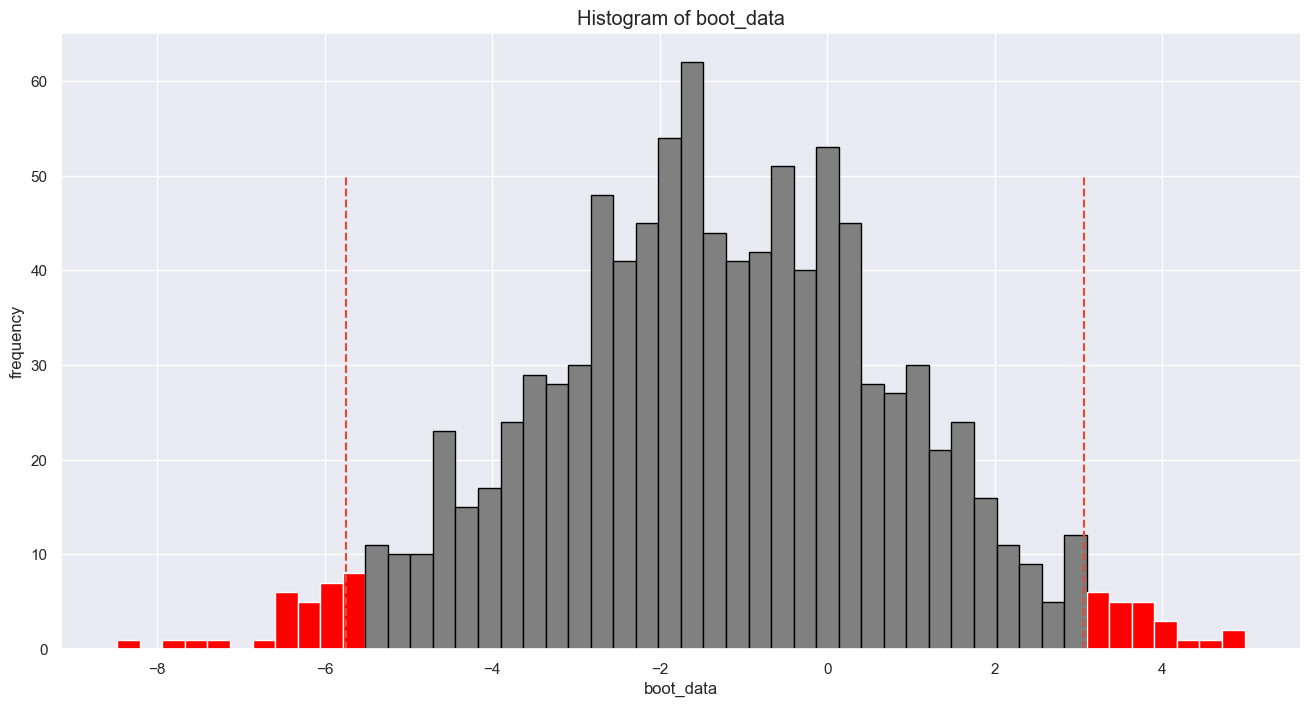

In [53]:
booted_data_arpu = get_bootstrap(a_total.revenue, b_total.revenue)

In [54]:
statistic_proof(booted_data_arpu['p_value'], alpha)

Значение p-value 0.5498
Нет оснований отклонить H0, влияние эксперимента на метрику не доказано


**Вывод**

Итак, во всех трех случаях у нас получилось значение p-value больше заявленного порога в 0,05 и также 0 попадает внутрь доверительного интервала разности средних двух подвыборок на бутстрапе - следовательно, отвергнуть нулевую гипотезу об отсутствии разницы между контрольной и тестовой выборками мы не можем.

**Можем сделать вывод, что набор акционных предложений не оказал статистически значимого влияния на ARPU**.

####   2.3.3. ARPPU (средняя выручка на платящего пользователя). 

Также проверим, как эксперимент повлиял на `ARPPU` разными методами.

**t-test на независимых выборках**

In [55]:
p_tt = stats.ttest_ind(a_paying['revenue'], b_paying['revenue'], equal_var = False)[1]

statistic_proof(p_tt, alpha)

Значение p-value 0.1002
Нет оснований отклонить H0, влияние эксперимента на метрику не доказано


**U-test Манна-Уитни**

In [56]:
p_mw = stats.mannwhitneyu(a_paying['revenue'], b_paying['revenue'])

statistic_proof(p_mw.pvalue, alpha)

Значение p-value 0.0
Отклоняем H0, есть статистически значимое влияние эксперимента


**Важная ремарка относительно использования Манна-Уитни**

Критерий Манна-Уитни в реальных задачах далеко не всегда применим, так как он обнаруживает статистически значимый эффект в большем числе случаев, чем у t-test. Проблема в том, что только после факта его срабатывания неверно говорить о приросте математического ожидания или медианы в тесте относительно контроля - стоит проверить наличие эффекта другими критериями и только после этого принять взвешенное решение, действительно ли наблюдаемый эффект статистически значим.

Именно частые срабатывания критерия Манна-Уитни делают его самым опасным и таким популярным критерием для анализа A/B-тестов.

Подробнее в источнике: https://habr.com/ru/companies/avito/articles/709596/.

**Бутстрап**

  0%|          | 0/1000 [00:00<?, ?it/s]

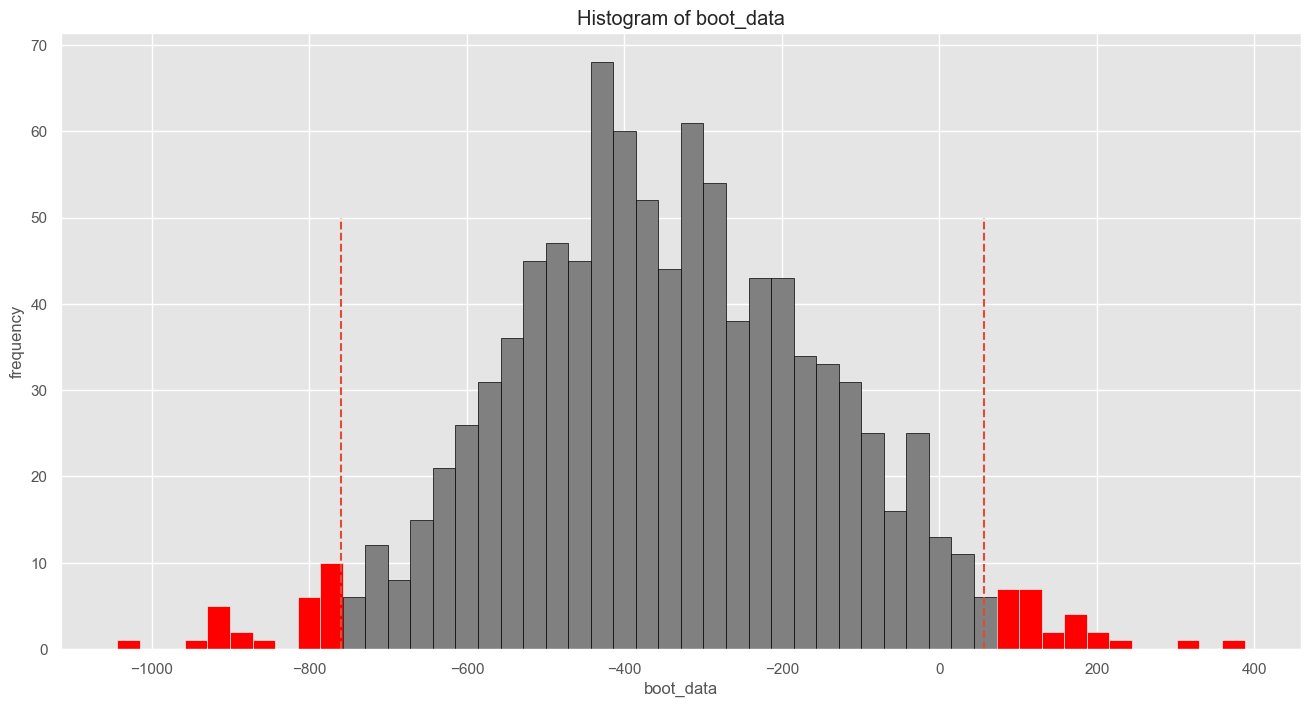

In [57]:
booted_data_arppu = get_bootstrap(a_paying.revenue, b_paying.revenue)

In [58]:
statistic_proof(booted_data_arppu['p_value'], alpha)

Значение p-value 0.0947
Нет оснований отклонить H0, влияние эксперимента на метрику не доказано


**Вывод**

Как и в предыдущем случае, по результатам t-test и бутстрапа у нас получилось значение p-value больше заявленного порога в 0,05 и 0 снова попал внутрь доверительного интервала разности средних двух подвыборок на бутстрапе - то есть мы не можем принять гипотезу о том, что эксперимент оказал статистически значимое влияние на метрику `ARPPU`.

**Влияние новых акционных предложений на ARPPU доказать также не удалось.**

Можно попробовать проанализировать выборку без выбросов - экстремально высоких значения выручки, и попробовать доказать, что новые акционне предложения возымели эффект только на эту группу пользователей. Применим бутстрап для наглядности.

  0%|          | 0/1000 [00:00<?, ?it/s]

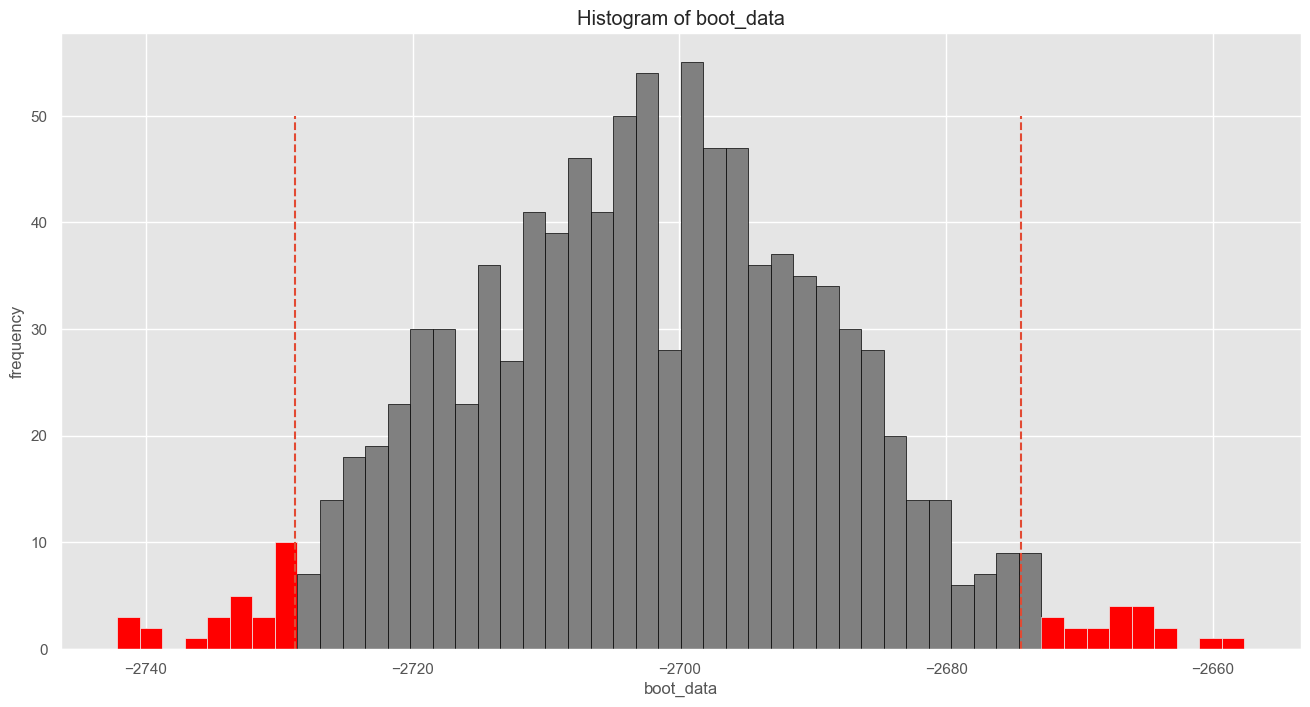

In [59]:
booted_data_arppu_lower_4000 = get_bootstrap(a_paying.query('revenue < 4000').revenue, b_paying.revenue)

In [60]:
statistic_proof(booted_data_arppu_lower_4000['p_value'], alpha)

Значение p-value 0.0
Отклоняем H0, есть статистически значимое влияние эксперимента


**Вывод**

Для игроков со средним чеком 2000-4000 удалось получить статистически значимое влияние эксперимента. Причем новые акционные условия повлияли на средний чек таких игроков ПОЗИТИВНО - мы наблюдаем выраженный положительный эффект с увеличением среднего чека на 2680-2720.

### 2.3. Результаты проверки влияния тестируемых акционных предложений на метрики.

В контрольной и тестовой группе данные распределились следующим образом:

- Контрольная группа (`группа a`): 202103 клиентов, из них 1928 совершали покупки крайне разнородного номинала - подавляющее большинство покупает на суммы 200-400, при этом есть 123 пользователя с покупками 30000+ (обеспечивают 89,4% всей выручки). При этом минимальным значением выручки является 200, максимальная выручка 37433, среднее 2664 и медиана 311 кардинально отличаюся (так как распределение сильно скошено вправо), конверсия в покупку составляет 0.95%.
- Тестовая группа (`группа b`): 202667 клиентов, из них 1805 совершали покупки с равномерным распределением выручки от 2000 до 4000, средняя выручка 3004, медианная с ней почти совпадает и равна 3022, конверсия в покупку составляет 0.89%.

Повторных покупок в обоих группах не было, все покупатели уникальны.
   
При оценке ключевых показателей `revenue`, `CR`, `ARPU`, `ARPPU` было выявлено следующее:

- общий объем выручки в тестовой группе на 5,56 % выше, чем в контрольной,
- средняя выручка с пользователя в тестовой группе больше на 5,26 %, чем в контрольной,
- средняя выручка с платящего пользователя после эксперимента выросла на 12,75%,
- при этом конверсия выше в контрольной группе: 0,95 % против  0,89 %, то есть эксперимент не оказал влияния на конверсию в покупку.

Статистическая оценка показателей с помощью критерия хи-квадрат (для конверсии), t-test для независимых выборок, непараметрическим U-test Манна-Уитни и техникой бутстреп показала, что:

- набор акционных предложений для тестовой группы оказал статистически значимое влияние на `CR` (то есть желание пользователей совершать покупки), однако, оно оказалось отрицательным и конверсия в покупку снизилась,
- если сравнивать конверсии в контрольной группе без чеков выше 4000 тысяч с тестовой конверсией, то окажется, что статистически значимо она НЕ ИЗМЕНИЛАСЬ,
- наличие статистически значимые различий в средних значениях `ARPU` и `ARPPU` для контрольной и тестовой групп не подтвердилось, однако, при проверке значений `ARPPU` у пользователей со средним чеком меньше 4000 удалось получить доказанное увеличение выручки с пользователя на 2680-2720.

Учитывая получившиеся результаты, сложно сделать однозначный вывод, необходимо внести уточнение либо в наши знания об аудитории, либо в понимание задач, которые стоят перед комадной. 

Например, смущает разное поведение пользователей в группах: в `группе a` большая часть пользователей приносит меньше выручки, чем в `группе b`, и лишь примерно 0,06% принесли в разы больше выручки - возможно, имеет место быть проблема со сплитованием аудитории перед проведением A/B теста, leak и смешение разных групп.Экспериментальная группа имеет более равномерные и стабильные с течением времени значени выручки - как в контроле, если не учитывать сверх высокие чеки. Возникает впечатление, что если из контрольной группы выкинуть покупателей в экстремальным средним чеком, то мы и получим тестовую выборку, по размеру они как раз совпадают.

Раз в общем выручка и `ARPPU` для тестовой группы выросли, а конверсия не упала (не берем в рассчет 123 человека с чеками 30к+), то можно говорить о том, что новая функциональность влияет положительно на покупателей со средними покупками - выручка с них статистически значимо выросла на 2700. А вот на игроков с экстремально высокими покупками функционально воздействует либо негативно, так как новых покупок они за это время не совепршили, либо никак и их высокие траты были обусловлены какими-то специальными или сезонными предложениями.

Подводя итоги и отвечая на вопрос, стоит ли выкатывать на всех пользователей новые наборы акционных предложений, я склоняюсь к положительному ответу, так как если из контрольной группы исключить выбросы влияющие на среднее значение, то тестовый набор предложений статистически доказано показывает себя лучше, исходя из средних значений гистограмм.

Важным нюансом в данном случае является то, что в целях экономии ресурса, функциональность можно раскатить только на пользователей с небольшими платежами 200-400, коих подавляющее большинство, так как на статистически доказанное увеличение среднего чека функциональность влияет только у них, а остальные пользователи не пользуются ей (и снижают конверсию, если считать всех вместе), эффект на них не доказан.

Стоит также понимать и какой вариант взаимодействия с аудиторией предпочтителен для бизнеса: работа с небольшим количеством игроков, активно тратящих большие суммы, или с большим количеством средне,но более равномерно и предсказуемо платящих пользователей. Важно поддерживать аудиторию среднеплатящих игроков, так как они обычно более стабильны, представляют меньше рисков.

Для полного анализа необходимо также оценить маржинальность предлагаемых наборов, дополнительные затраты и воронки продаж.

## 3. Рекомендация и анализ метрик для оценки удовлетворенности аудитории новым тематическим событием в мобильной игре.

В игре `Plants & Gardens` каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. 

Задачи:

- составить рекомендации с помощью каких метрик можно оценить результаты последнего прошедшего события,
- решить, изменится ли набор метрик оценки результата, если в другом событии усложнить механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. 

В качестве оценки прошедшего ивента можно использовать следующие метрики:

**Упрощенная механика**

- `DAU`, `MAU` (если ивент длится больше месяца) - сравнить их с аналогичными метриками за неделю/месяц до ивента, это поможет оценить количество уникальных пользователей в тематические дни и в обычные, а также заинтересованность аудитории в проведении ивента;

- `Sticky factor` (недельный и месячный) - сравнить коэффициенты "липучести" в дни/месяцы, когда проводятся проводятся тематические события и в обычные дни для оценки лояльости аудитории;

- `Conversion rate` (абсолютный и относительный) - позволят определить как проведение тематических событий сказывавается на привлечении новой аудитории;

- в целом стоит оценить `воронку конверсии пользователей` и их "доходимость" от одного события/уровня к другому, проанализировать на каких уровнях заканчивают игроки (возможно, какой-то уровень не очень балансный и на нём многие отваливаются, это можно будет увидеть по бОльшему проценту `churn rate` игроков конкретно на этом уровне), проверить какой процент игроков дошел до финального уровня ивента;

- `Retention n-ого дня`, `Rolling Retention` - сколько игроков заходили в ивент и аналогичный период n-дней назад, иными словами процент возврата игроков во время ивента; можно выделить несколько когорт (событие а,  событие в, событие с) и сравнивать `retention` этих групп (кривая 'выживания' и heatmap помогут понять становится ли `retention` личше или хуже после произошедшего события в игре);

- `ARPU` и `ARPPU` - оценить, сколько люди донатят во время прохождения уровней, если есть микротранзакции за дополнительные покупки при прохождении сложных уровней и дополнительные ограниченные награды,

- `ASL` (cуммарная продолжительность сессий за период / общее количество сессий за тот же период) - сравнить среднюю продолжительность сессии в обычный день и тематический, это позволит определить как тематическое событие влияет на время, которое пользователь проводит в приложении;

- `интервалы между сессиями` - определить имеется ли влияние тематических событий на желание пользователя возвращаться в игру (сравнить с обычным днём);

- `ACU` (в часах) - определить период времени в сутках с наибольшим кол-вом пользователей, рассчитать среднее число         пользователей за час, сравнить показатель с тематическими днями;

- `Customer satisfaction score (CSAT)` - можно провести опрос после проведенного события об удовлетворенности им, чтобы получить фидбек от игроков и показать клиентоориентированность;

- также можно посмотреть на `CAC` (стоимость привлечения новых игроков) во время ивента и вне его, поскольку награды и ограниченное предложение могут мотивировать бОльшее количество игроков начать играть.


И, конечно, для валидации результатов по этим метрикам стоит проводить A/B-тесты и оценивать их на статистичскую значимость.

**Усложненная механика**

Для усложненной механики все перечисленные метрики выше пригодны. Однако, учитывая, что механика усложнилась и у игроков появился риск потерять свой прогресс, в целом можно ожидать, что это негативно скажется на вышеописанных метриках, особенно на `Convertion rate` и `retention`, так как менее активные игроки с меньшей вероятностью откроют все награды, а игроки долго отсутсвовавшие в игре вряд ли смогут закрыть ивент из-за отставания.

Стоит проанализировать не только на каком уровне игроки заканчивают, но и на каких уровнях проигрывали - так будет понятнее, какие уровни оказались слишком сложными и учесть это в будущем. 

Также можно учитывать следующие дополнительно метрики:

- `доля пользователей, которые вышли после первого неудачной попытки` - неудачная попытка и откат это негативные события, соответственно новая механика влияет на усилением негативного впечатления пользователя, и понимание того, вышел игрок из игры или остался в ней после неудачной попытки позволит оценить, насколько сильное оказывает влияние откат;

- `средняя продолжительность игры после неудачной попытки` - позволит оценить влияние отката на желания пользователя продолжать игру;
- `среднее кол-во откатов` - позволит оценить "терпение аудитории" и балансно настроить нашу игровую механику.